In [1]:
# for data analysis
import pandas as pd
import numpy as np

# unsupervised learning model for clustering
# customers into new segements
from sklearn.cluster import KMeans
# for splitting data into train/test sub-sets
from sklearn.model_selection import train_test_split
# for evaluating predictions
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# for evaluating features
from sklearn.model_selection import cross_validate, ShuffleSplit
# for spliting features into combinations
from itertools import combinations
# for training Linear regression model
from sklearn.linear_model import LogisticRegression
# for calibrating probability curves
from sklearn.calibration import calibration_curve, CalibratedClassifierCV 

# statistics
import scipy.stats as stats

# constant for random state
RANDOM_STATE = 42

# statistical visualizations
import seaborn as sns

# for data visualization
import matplotlib.pyplot as plt
from matplotlib import cm
plt.style.use('ggplot')

**Project content**

1. DATA MANIPULATION TASK
    * select random subsample of data set;
    * filter desired rows using simple and more complex conditions;
    * drop unnecessary variables, rename some variables;
    * calculate summarizing statistics (for full sample and by categorical variables as well);
    * create new variables using simple transformation and custom functions;
    * order data set by several variables.
2. DATA VISUALISATION TASK
    * visualize data. Free to select the scope, types of plots, etc.
3. MODELLING TASK
    * Perform a logistic regression to obtain the predicted probability that a customer has subscribed for a term deposit. Use continuous variables and dummy variables created for categorical columns. Not necessarily all variables provided in data sample should be used. Evaluate model goodness of fit and predictive ability. If needed, data set could be split into training and test sets.

In [2]:
# load data
df_bank = pd.read_csv('data/bank.csv', delimiter=';')
df_bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [3]:
# load data
df_bank_full = pd.read_csv('data/bank-full.csv', delimiter=';')
df_bank_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# Documentation 

In [4]:
# read .txt file
with open('data/bank-names.txt', 'r') as reader:
    print(reader.read())

Citation Request:
  This dataset is public available for research. The details are described in [Moro et al., 2011]. 
  Please include this citation if you plan to use this database:

  [Moro et al., 2011] S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, GuimarÃ£es, Portugal, October, 2011. EUROSIS.

  Available at: [pdf] http://hdl.handle.net/1822/14838
                [bib] http://www3.dsi.uminho.pt/pcortez/bib/2011-esm-1.txt

1. Title: Bank Marketing

2. Sources
   Created by: Paulo Cortez (Univ. Minho) and SÃ©rgio Moro (ISCTE-IUL) @ 2012
   
3. Past Usage:

  The full dataset was described and analyzed in:

  S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. 
  In P. Novais et al. (Eds.), Proceedings of the European

In [5]:
# reduce memory
# reduce memory usage if available
def reduce_mem_usage(df, df_name, verbose=True):
    """
    This function changes pandas numerical dtypes (reduces bit size if possible)
    to reduce memory usage
    
    :param df: pandas DataFrame
    :param df_name: str, name of DataFrame
    :param verbose: bool, if True prints out message of how much memory usage was reduced
        
    :return:  pandas DataFrame       
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float64)
                else:
                    df[col] = df[col].astype(np.float64)
    # calculate memory after reduction
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        # reduced memory usage in percent
        diff_pst = 100 * (start_mem - end_mem) / start_mem
        msg = f'{df_name} mem. usage decreased to {end_mem:5.2f} Mb ({diff_pst:.1f}% reduction)'
        print(msg)
    return df

In [6]:
df_bank_full = reduce_mem_usage(df_bank_full, "df_bank_full")
df_bank = reduce_mem_usage(df_bank, "df_bank")

df_bank_full mem. usage decreased to  4.57 Mb (22.1% reduction)
df_bank mem. usage decreased to  0.45 Mb (23.5% reduction)


# DATA MANIPULATION TASK <a class="anchor" id="first-bullet"></a>

In [7]:
print(f'df_bank_full DataFrame contains: {len(df_bank_full)} rows.')
print(f'df_bank      DataFrame contains: {len(df_bank)} rows.')

df_bank_full DataFrame contains: 45211 rows.
df_bank      DataFrame contains: 4521 rows.


## Task 1

* Select random subsample of data set.

In [8]:
# select N random subsample of data set
N = 100
# random state parameter is used for reproducibility
df_sample = df_bank_full.sample(N, random_state=RANDOM_STATE)
# return 5 first rows of random sample
df_sample.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3776,40,blue-collar,married,secondary,no,580,yes,no,unknown,16,may,192,1,-1,0,unknown,no
9928,47,services,single,secondary,no,3644,no,no,unknown,9,jun,83,2,-1,0,unknown,no
33409,25,student,single,tertiary,no,538,yes,no,cellular,20,apr,226,1,-1,0,unknown,no
31885,42,management,married,tertiary,no,1773,no,no,cellular,9,apr,311,1,336,1,failure,no
15738,56,management,married,tertiary,no,217,no,yes,cellular,21,jul,121,2,-1,0,unknown,no


## Task 2

* Filter desired rows using simple and more complex conditions.

In [9]:
# select all data for august month
df_aug = df_bank_full.loc[df_bank_full.month == 'aug']
# return first 5 rows
df_aug.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
18823,58,admin.,married,secondary,no,6878,no,no,cellular,4,aug,148,1,-1,0,unknown,no
18824,51,technician,divorced,secondary,no,1063,no,yes,cellular,4,aug,78,1,-1,0,unknown,no
18825,56,services,married,tertiary,no,3480,no,no,cellular,4,aug,124,1,-1,0,unknown,no
18826,47,management,married,tertiary,no,0,no,no,cellular,4,aug,491,1,-1,0,unknown,no
18827,32,management,married,tertiary,no,1570,no,no,cellular,4,aug,156,1,-1,0,unknown,no


In [10]:
# generate 3 conditions

# select only students, retired and unemployed data entries
cond_1 = df_bank_full.job.isin(['student', 'retired', 'unemployed'])
# select contact communication type only "cellular" 
cond_2 = df_bank_full.contact == 'cellular'
# average yearly balance (in euros) is at least 1000 eur.
cond_3 = df_bank_full.balance >= 1000

# new DataFrame with 3 conditions
df_cond = df_bank_full.loc[cond_1 & cond_2 & cond_3]
# return first 5 rows
df_cond.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
12818,51,retired,married,secondary,no,3003,yes,no,cellular,7,jul,149,3,-1,0,unknown,no
12915,52,unemployed,married,tertiary,no,1023,no,no,cellular,7,jul,107,6,-1,0,unknown,no
13078,57,retired,married,tertiary,no,1029,no,yes,cellular,8,jul,203,1,-1,0,unknown,no
13143,42,unemployed,divorced,secondary,no,2699,no,no,cellular,8,jul,92,2,-1,0,unknown,no
13183,60,retired,married,secondary,no,1141,no,yes,cellular,8,jul,211,2,-1,0,unknown,no


In [11]:
# use query (SQL-like) function to select all entries with housing during July month and
# the number of contacts performed during this campaign is greater than or equal to 3
df_query = df_bank_full.query('month == "jul" & campaign >= 3')
# return first 5 rows
df_query.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
12443,59,retired,married,secondary,yes,49,no,yes,unknown,1,jul,602,4,-1,0,unknown,no
12444,41,services,married,secondary,no,138,yes,no,unknown,1,jul,136,3,-1,0,unknown,no
12445,30,blue-collar,married,secondary,no,365,no,no,unknown,1,jul,381,4,-1,0,unknown,no
12447,41,blue-collar,single,secondary,no,75,yes,no,unknown,1,jul,479,9,-1,0,unknown,yes
12448,31,blue-collar,married,secondary,no,652,no,yes,unknown,1,jul,281,3,-1,0,unknown,no


## Task 3
* drop unnecessary variables, rename some variables.

In [12]:
# delete y column from sample DataFrame
# before
df_sample.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
3776,40,blue-collar,married,secondary,no,580,yes,no,unknown,16,may,192,1,-1,0,unknown,no
9928,47,services,single,secondary,no,3644,no,no,unknown,9,jun,83,2,-1,0,unknown,no
33409,25,student,single,tertiary,no,538,yes,no,cellular,20,apr,226,1,-1,0,unknown,no
31885,42,management,married,tertiary,no,1773,no,no,cellular,9,apr,311,1,336,1,failure,no
15738,56,management,married,tertiary,no,217,no,yes,cellular,21,jul,121,2,-1,0,unknown,no


In [13]:
# after
del df_sample['y']
df_sample.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
3776,40,blue-collar,married,secondary,no,580,yes,no,unknown,16,may,192,1,-1,0,unknown
9928,47,services,single,secondary,no,3644,no,no,unknown,9,jun,83,2,-1,0,unknown
33409,25,student,single,tertiary,no,538,yes,no,cellular,20,apr,226,1,-1,0,unknown
31885,42,management,married,tertiary,no,1773,no,no,cellular,9,apr,311,1,336,1,failure
15738,56,management,married,tertiary,no,217,no,yes,cellular,21,jul,121,2,-1,0,unknown


In [14]:
# capitalize all column name first letters
df_sample.columns = [col.title() for col in df_sample.columns]
df_sample.head()

,Age,Job,Marital,Education,Default,Balance,Housing,Loan,Contact,Day,Month,Duration,Campaign,Pdays,Previous,Poutcome
3776,40,blue-collar,married,secondary,no,580,yes,no,unknown,16,may,192,1,-1,0,unknown
9928,47,services,single,secondary,no,3644,no,no,unknown,9,jun,83,2,-1,0,unknown
33409,25,student,single,tertiary,no,538,yes,no,cellular,20,apr,226,1,-1,0,unknown
31885,42,management,married,tertiary,no,1773,no,no,cellular,9,apr,311,1,336,1,failure
15738,56,management,married,tertiary,no,217,no,yes,cellular,21,jul,121,2,-1,0,unknown


In [15]:
# rename Job column to Work
df_sample.rename(columns={'Job': 'Work'}, inplace=True)
df_sample.head()

,Age,Work,Marital,Education,Default,Balance,Housing,Loan,Contact,Day,Month,Duration,Campaign,Pdays,Previous,Poutcome
3776,40,blue-collar,married,secondary,no,580,yes,no,unknown,16,may,192,1,-1,0,unknown
9928,47,services,single,secondary,no,3644,no,no,unknown,9,jun,83,2,-1,0,unknown
33409,25,student,single,tertiary,no,538,yes,no,cellular,20,apr,226,1,-1,0,unknown
31885,42,management,married,tertiary,no,1773,no,no,cellular,9,apr,311,1,336,1,failure
15738,56,management,married,tertiary,no,217,no,yes,cellular,21,jul,121,2,-1,0,unknown


## Task 4

* calculate summarizing statistics (for full sample and by categorical variables as well).

In [16]:
# ugly, but quick way to get basic summurizing statistics for continues numerical variables
df_bank_full.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [17]:
# count missing values per column
df_bank_full.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [18]:
# create custom function for calculating summarizing statistics
def summary_stats(df, col_name):
    """
    This function prints out summarizing statistics for both numerical and categorical variables
    
    :param df: pandas DataFrame
    :param col_name: str, name of DataFrame
        
    :return:  None     
    """
    # list of numeric dtypes
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    if df[col_name].dtype in numerics:
        print(f'"{col_name}" is continous numerical variable')
        # calculate mean, median and standard deviation
        _mean = df[col_name].mean()
        _median = df[col_name].median()
        _std = df[col_name].std()
        print(f'Mean: {_mean:.1f}, Median: {_median:.1f}, STD {_std:.1f}')
        # calculate skewness and kurtosis
        _skew = df[col_name].skew()
        _kurt = df[col_name].kurtosis()
        print(f'Skewness: {_skew:.2f}, kurtosis {_kurt:.2f}')
        
        if _skew >= 1:
            print('Right (possitive) skewned distribution')
        if _skew <= -1:
            print('Left (negative) skewned distribution')    
    else:
        print(f'"{col_name}" is categorical variable')
        # count categorical values
        _values = pd.DataFrame(df_bank_full[col_name].value_counts())
        # calculate value precentange of whole dataset
        _values['pct'] = _values[col_name] / len(df_bank_full) * 100
        print(f"{len(_values)} categories found.")
        if len(_values) > 5:
            print('TOP 5 categories:')
            # get only top 5 values
            _values = _values.sort_values(by=col_name, ascending=False).head(5)
            
        for idx in _values.index:
            _cnt = _values.loc[idx, col_name]
            _pct = _values.loc[idx, 'pct']
            print(f"{idx:15s} {_cnt} values represent {_pct:.1f}% of all data.")

In [19]:
# iterate over column names
for col_name in df_bank_full.columns:
    # print out 
    summary_stats(df_bank_full, col_name)
    # add emty row after calculations
    if col_name != 'y':
        print()

"age" is continous numerical variable
Mean: 40.9, Median: 39.0, STD 10.6
Skewness: 0.68, kurtosis 0.32

"job" is categorical variable
12 categories found.
TOP 5 categories:
blue-collar     9732 values represent 21.5% of all data.
management      9458 values represent 20.9% of all data.
technician      7597 values represent 16.8% of all data.
admin.          5171 values represent 11.4% of all data.
services        4154 values represent 9.2% of all data.

"marital" is categorical variable
3 categories found.
married         27214 values represent 60.2% of all data.
single          12790 values represent 28.3% of all data.
divorced        5207 values represent 11.5% of all data.

"education" is categorical variable
4 categories found.
secondary       23202 values represent 51.3% of all data.
tertiary        13301 values represent 29.4% of all data.
primary         6851 values represent 15.2% of all data.
unknown         1857 values represent 4.1% of all data.

"default" is categorical var

## Task 5
* create new variables using simple transformation and custom functions.

In [20]:
# before adding new features
df_bank_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [21]:
# create new feature from unsupervised learning
# cluster customers into 5 groups
# based on their age, balance and last contact duration
X = df_bank_full[['age', 'balance', 'duration']]
kmeans = KMeans(n_clusters=5, random_state=RANDOM_STATE).fit(X)
df_bank_full['cluster_no'] = kmeans.labels_
df_bank_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,cluster_no
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,3
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,0


In [22]:
_ = df_bank_full['cluster_no'].value_counts() / len(df_bank_full) * 100
print('Cluster reresents (% of data)')
_.round(1)

Cluster reresents (% of data)


0    80.0
3    15.4
1     3.8
4     0.7
2     0.1
Name: cluster_no, dtype: float64

In [23]:
# create new variable with date from 2 columns
df_bank_full['dummy_date'] = df_bank_full.apply(lambda x: f"{x['month']}-{x['day']}", axis=1)
df_bank_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,cluster_no,dummy_date
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,3,may-5
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,0,may-5
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,0,may-5
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,0,may-5
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,0,may-5


If year data was available, I could create new features, e.g. weekeday, holiday.
* From **[Moro et al., 2011]** paper:
    
    "*The dataset collected is related to 17 campaigns that occurred between May 2008 and November 2010, corresponding to a total of 79354 contacts.*"
    
Real date can't be extracted from provided dataset.

In [24]:
# cut customers into 5 groups based on age quantiles
ser, bins = pd.qcut(df_bank_full['age'], 5, duplicates='drop', retbins=True, labels=False)
df_bank_full['age_range'] = ser
df_bank_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,cluster_no,dummy_date,age_range
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no,3,may-5,4
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no,0,may-5,3
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no,0,may-5,1
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no,0,may-5,3
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no,0,may-5,1


In [25]:
print('Age groups')
for _bin in range(len(bins) - 1):
    _range = f'({bins[_bin]} - {bins[_bin+1]}]'
    # first range includes first bin
    if not _bin: _range = '[' + _range[1:]
    # count values and percentage this age range represent of all data
    _ = (df_bank_full.age_range ==_bin)
    print(f'{_range} {_.sum()} values ({_.mean()*100:.1f}% of all data)')

Age groups
[18.0 - 32.0] 11111 values (24.6% of all data)
(32.0 - 36.0] 7602 values (16.8% of all data)
(36.0 - 42.0] 8537 values (18.9% of all data)
(42.0 - 51.0] 9642 values (21.3% of all data)
(51.0 - 95.0] 8319 values (18.4% of all data)


## Task 6

* order data set by several variables.

In [26]:
# order by average yearly balance, in euros and 
# by last contact duration, in seconds
df_sample = df_sample.sort_values(by=['Balance', 'Duration'])

# get top 5 rows
df_sample.head()

,Age,Work,Marital,Education,Default,Balance,Housing,Loan,Contact,Day,Month,Duration,Campaign,Pdays,Previous,Poutcome
34619,43,blue-collar,married,secondary,no,-755,yes,yes,cellular,5,may,162,1,337,1,failure
26191,49,self-employed,divorced,secondary,no,-478,yes,yes,cellular,20,nov,291,1,-1,0,unknown
5847,31,blue-collar,divorced,secondary,no,-452,yes,no,unknown,26,may,182,5,-1,0,unknown
38857,31,technician,single,secondary,no,-348,yes,no,cellular,18,may,410,1,-1,0,unknown
25089,45,self-employed,married,tertiary,no,-312,no,no,telephone,18,nov,46,4,-1,0,unknown


In [27]:
# get botom 5 rows
df_sample.tail()

,Age,Work,Marital,Education,Default,Balance,Housing,Loan,Contact,Day,Month,Duration,Campaign,Pdays,Previous,Poutcome
1470,60,blue-collar,divorced,primary,no,7601,yes,no,unknown,8,may,285,1,-1,0,unknown
2055,51,blue-collar,married,tertiary,no,7816,yes,no,unknown,12,may,76,2,-1,0,unknown
9604,36,services,married,secondary,no,8114,yes,no,unknown,6,jun,505,1,-1,0,unknown
26528,32,blue-collar,married,secondary,no,10142,yes,no,cellular,20,nov,249,1,-1,0,unknown
29675,33,unemployed,single,tertiary,no,14889,yes,no,cellular,3,feb,22,3,-1,0,unknown


# DATA VISUALISATION TASK

* visualize all features.

In [28]:
# reload data again so that all data modifications in TASK 1 are excluded
df_bank_full = pd.read_csv('data/bank-full.csv', delimiter=';')
df_bank_full.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


## Numerical features

* create custom function for visualizing numerical features

### Helper functions

In [29]:
def plot_num_dist(df, col_name, xlabel=''):
    """
    This function plots figure with histogram and box-plot for numerical feature.
    :param df: pandas DataFrame
    :param col_name: str, column name
    :param xlabel: str, x-axis label
    
    :return: None
    """
    # both figures shares x-axis range
    fig, axes = plt.subplots(2, 1, figsize=(16, 6), sharex=True)
    
    # check if column name is present in provided DataFrame
    if col_name not in df.columns:
        print(f'{col_name} column not found in provided DataFrame.')
        return None
    
    """
    Top plot
    """
    # calculate bins
    if df_bank_full[col_name].nunique() <= 100:
        bins = df_bank_full[col_name].nunique()+1
    else:
        bins = 200
        
    # histogram plot
    axes[0].hist(df_bank_full[col_name], bins=bins)
    
    # draw Q1 (quartile 1), mean, median amd Q3 lines
    axes[0].axvline(df_bank_full[col_name].quantile(0.25), color='k', alpha=0.7, linewidth=3)
    axes[0].axvline(df_bank_full[col_name].mean(), color='#0066cc', linewidth=4, label='Mean')
    axes[0].axvline(df_bank_full[col_name].median(), color='#65a2c8', linewidth=4, label='Median')
    axes[0].axvline(df_bank_full[col_name].quantile(0.75), color='k', alpha=0.7, linewidth=3)
    
    # add y-axis label
    axes[0].set_ylabel('count')
    
    # add legend with white background
    legend = axes[0].legend(frameon=1)
    frame = legend.get_frame()
    frame.set_facecolor('w')
    
    """
    Botom plot
    """
    # box-plot
    bplot = axes[1].boxplot(df_bank_full[col_name], vert=False, patch_artist = True)
    
    # change box-plot fill color
    bplot['boxes'][0].set_facecolor('#e24a33')
        
    # change box-plot median line width and color
    bplot['medians'][0].set(color='#65a2c8', linewidth=3) 
    
    # change face color
    # remove y-axis ticks
    axes[1].set_yticks([])
    # add custom x-axis label if provided
    if xlabel:
        axes[1].set_xlabel(xlabel)
    else:
        axes[1].set_xlabel(col_name.title())    

In [30]:
def plot_num_qcut(df, col_name, xlabel='', N=5, ylog=False):
    """
    This function plots figure with histogram and box-plot for numerical feature.
    :param df: pandas DataFrame
    :param col_name: str, column name
    :param xlabel: str, x-axis label
    :param N: int, number of quantiles to cut data
    :param ylog: bool, if True, left plot y-axis is log scaled
    
    :return: None
    """
    # cut customers into 10 groups based on age quantiles
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # check if column name is present in provided DataFrame
    if col_name not in df.columns:
        print(f'{col_name} column not found in provided DataFrame.')
        return None
    
    # generate colors for ploting
    # first color is blue, last is red
    colors = cm.get_cmap('viridis', N)
    colors = [colors(i) for i in range(colors.N)]
    
    """
    Right plot
    """       
    # cut data into N groups based on age quantiles
    ser = pd.qcut(df_bank_full[col_name], N, duplicates='drop', labels=False)
    # plot barplot of new quantiles
    _bar_data = ser.value_counts().sort_index()
    barplot = axes[1].bar(_bar_data.index, _bar_data)
    
    # draw mean quantiles value
    _mean_cnt = pd.Series(ser).value_counts().mean()
    
    # calculate mean difference
    _mean_diff = (abs(pd.Series(ser).value_counts() - _mean_cnt)).mean()
    axes[1].axhline(_mean_cnt, color='r', label=f'{_mean_diff:.1f} count error')
    
    # add x-axis labels
    axes[1].set_xlabel(col_name.title() + ' groups') 
    
    # add legend with white background
    legend = axes[1].legend(frameon=1)
    frame = legend.get_frame()
    frame.set_facecolor('w')
    
    """
    Left plot
    """ 
    # calculate bins
    if df_bank_full[col_name].nunique() <= 100:
        bins = np.linspace(df_bank_full[col_name].min(), df_bank_full[col_name].max(), df_bank_full[col_name].nunique()+1)
    else:
        bins = np.linspace(df_bank_full[col_name].min(), df_bank_full[col_name].max(), 201)
    
    # plot multiple historgrams based on the number N
    for s in sorted(ser.unique()):
        axes[0].hist(df.loc[ser == s, col_name], bins=bins, color=colors[s])
        # recolor bar blot
        barplot[s].set_color(colors[s])
        
    # change y-axis scale
    if ylog:
        axes[0].set_yscale('log')
    
    # add y-axis label
    axes[0].set_ylabel('count')
    axes[0].set_xlabel(xlabel.title()) 

In [31]:
def prob_plot(df, col_name, N=5):
    """
    This function plot proportions of subscribed customers based on column and number of quantiles data was split.
    :param df: pandas DataFrame
    :param col_name: str, column name
    :param N: int, number of quantiles to cut data
    
    :return: None
    """
    # q-cut data into N quantiles
    ser = pd.qcut(df[col_name], N, duplicates='drop', labels=False)
    
    # temp. DdataFrame for visualizing predictions
    _df = df[[col_name, 'y']].copy()
    _df['y'].replace({'no': 0, 'yes': 1}, inplace=True)
    _df[f'{col_name}_group'] = ser
    
    # count propotions each age group subscribed to long-term deposits
    fig, ax = plt.subplots(1, 1, figsize=(16, 4))
    ax.plot(_df.groupby(f'{col_name}_group')['y'].mean()*100, 'o-', label=f'Subscription rate per {col_name} group')
    
    # horizontal line to show mean subscription rate per group
    ax.axhline(_df['y'].mean()*100, label='Mean subscription proportion', color='k', alpha=0.7)
    
    # add legend with white background
    legend = ax.legend(frameon=1)
    frame = legend.get_frame()
    frame.set_facecolor('w')
    
    # add axis labels
    ax.set_ylabel('Subscribed (%)')
    ax.set_xlabel(f'{col_name} group'.title())

### Age

* age (years).

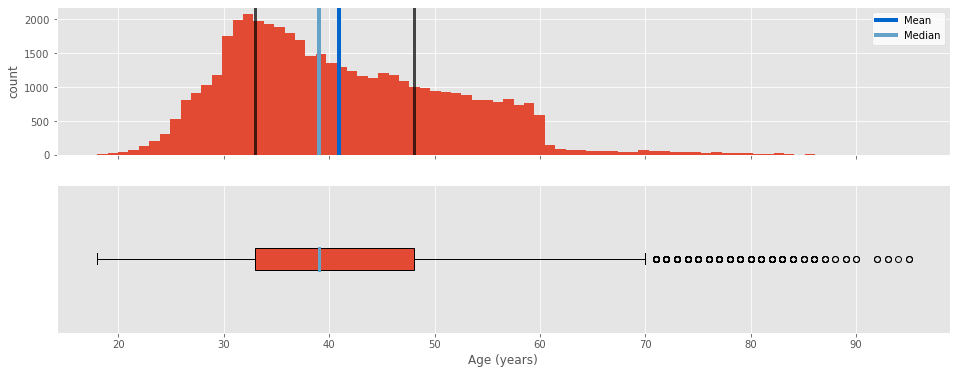

In [32]:
plot_num_dist(df_bank_full, 'age', 'Age (years)')

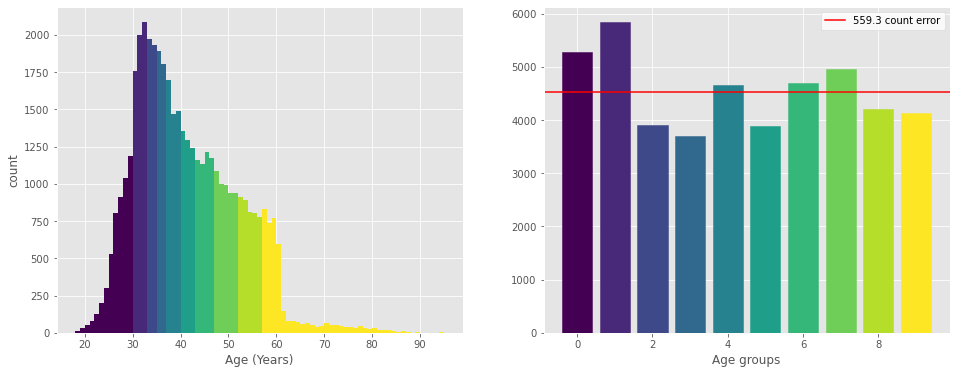

In [33]:
plot_num_qcut(df_bank_full, 'age', xlabel='Age (years)', N=10)

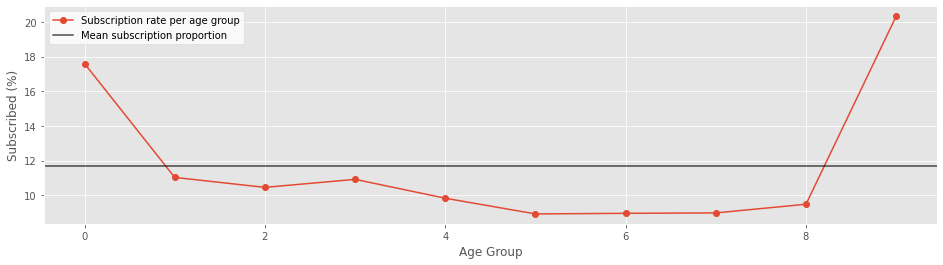

In [34]:
prob_plot(df_bank_full, 'age', 10)

From figure above we know that 10 deciles are almost equal size. Therefore, proportions between different age groups can be compared it seems that both youngest and oldest customers have higher subscription rate (proportion of subscribed accounts).

### Balance 

* balance: average yearly balance, in euros (numeric).

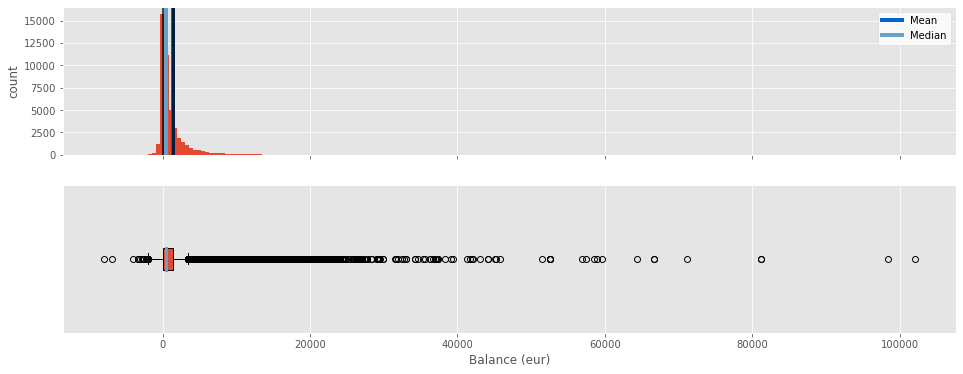

In [35]:
plot_num_dist(df_bank_full, 'balance', 'Balance (eur)')

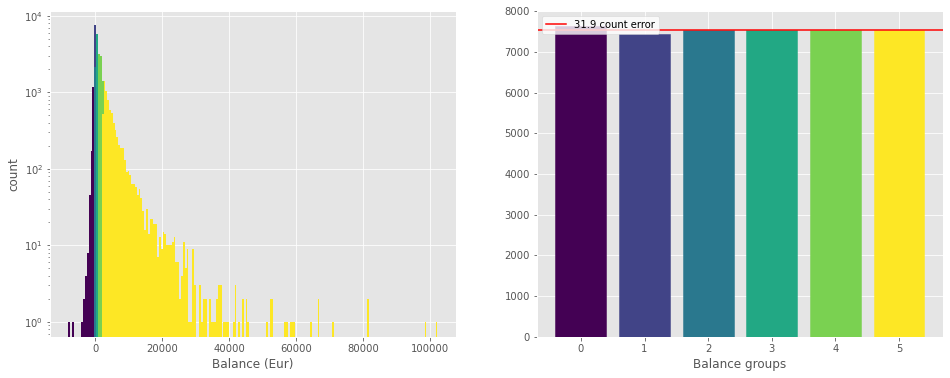

In [36]:
plot_num_qcut(df_bank_full, 'balance', xlabel='Balance (eur)', N=6, ylog=True)

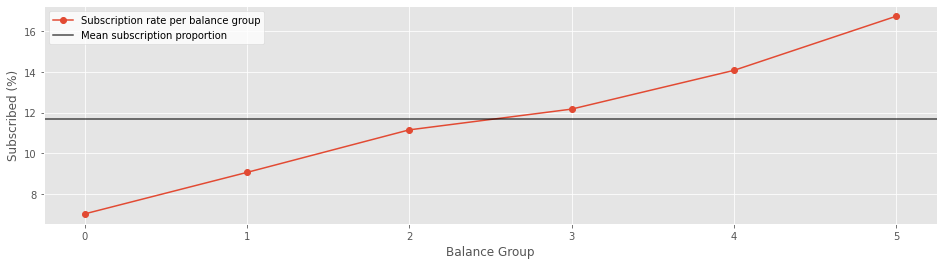

In [37]:
# very inbalanced, right-skewed distribution 
prob_plot(df_bank_full, 'balance', 6)

In [38]:
# from figures above it is cleat that people with low bank balance is less likely to subscribe for deposits
# let's distribute data into 2-groups: below median and above

# temp DataFrame for quick calculations
_df = df_bank_full[['balance', 'y']].copy()
_df.y.replace({'no': 0, 'yes': 1}, inplace=True)

# calculate median
_median = _df.balance.median()
print(f'Median balance: {_median:.0f} euros.')

# create new feature whatever data is above median or below
_df['median_split'] = (_df.balance >= _median).astype(int).replace({0: 'below median balance', 1: 'above median balance'})

# groupby object
subscribed_groups = _df.groupby('median_split')['y']

# stadard deviation
std_p = lambda x: np.std(x, ddof=0)
# standard error
se_p = lambda x: stats.sem(x, ddof=0)

# calcualte stats
subscribed_groups = subscribed_groups.agg([np.mean, std_p, se_p])
# rename columns
subscribed_groups.columns = ['Proportion', "STD", 'SEM']
subscribed_groups.round(3)

# I stoped doing statistical tests, because task is for visualizing data 
# and not for finding statistically significant features

Median balance: 448 euros.


,Proportion,STD,SEM
median_split,,,
above median balance,0.143,0.350,0.002
below median balance,0.091,0.287,0.002


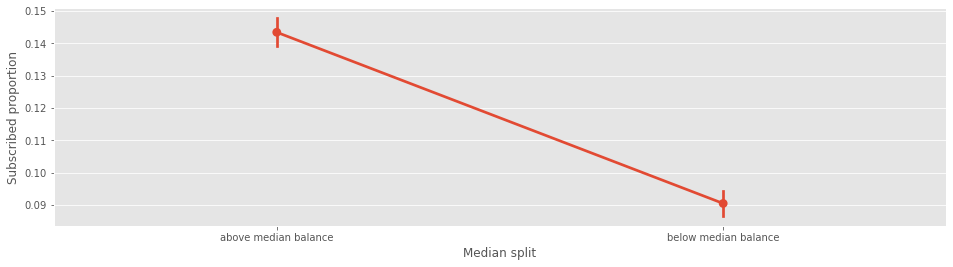

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
# Draw a nested barplot by species and sex
sns.pointplot(x="median_split", y="y", data=_df, dodge=True, ax=ax)
ax.set_ylabel('Subscribed proportion')
ax.set_xlabel('Median split');

### Day

* day: last contact day of the month (numeric).

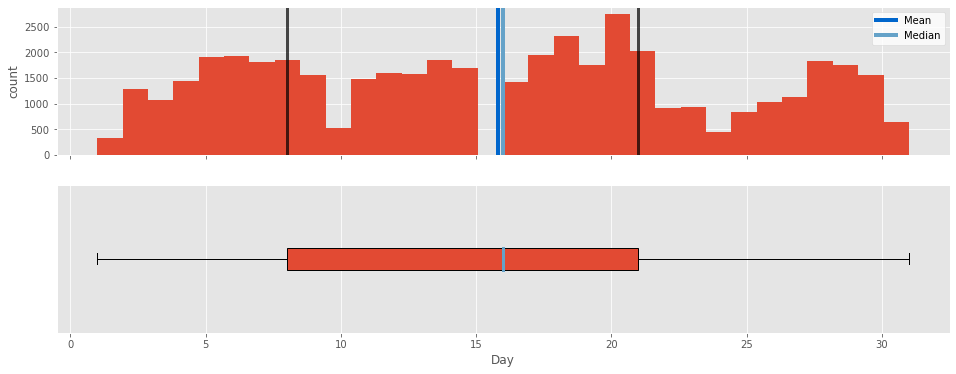

In [40]:
plot_num_dist(df_bank_full, 'day')

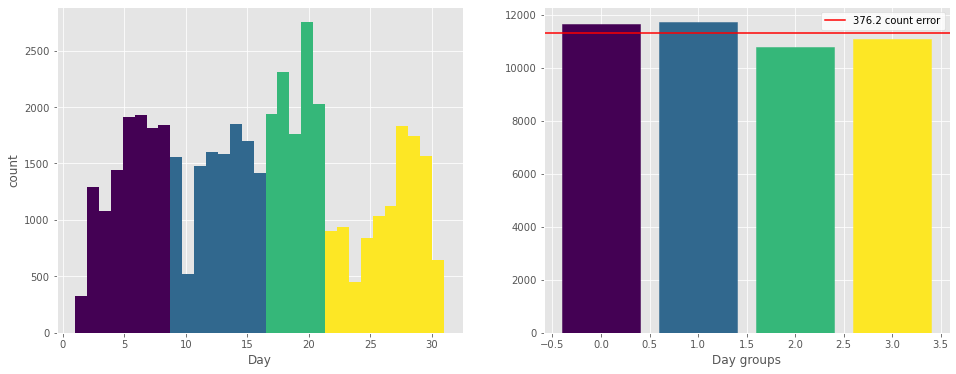

In [41]:
plot_num_qcut(df_bank_full, 'day', xlabel='Day', N=4)

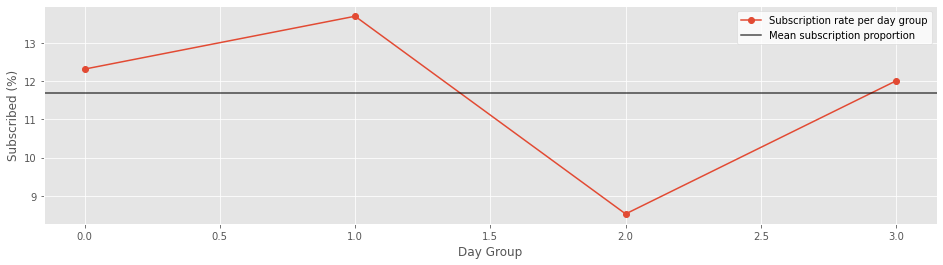

In [42]:
# days can be split into 4 almost equal ranges
prob_plot(df_bank_full, 'day', 4)

There is no well defined trend. While it seems that at the begining of the month, subscription proportion is higher than at the second half, such hypothesis can be only tested with statistical tests and not with visual plotting. In addition, days histogram looks uniform. Week day would be more informative feature to analyze.

### Duration

* duration: last contact duration, in seconds (numeric).

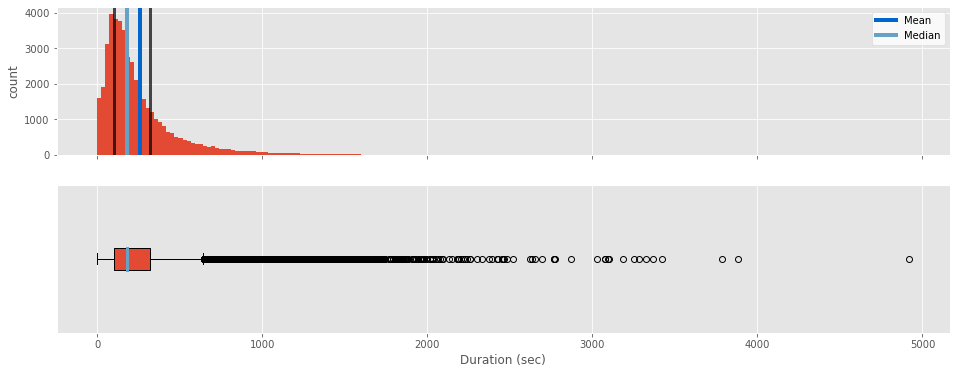

In [43]:
plot_num_dist(df_bank_full, 'duration', 'Duration (sec)')

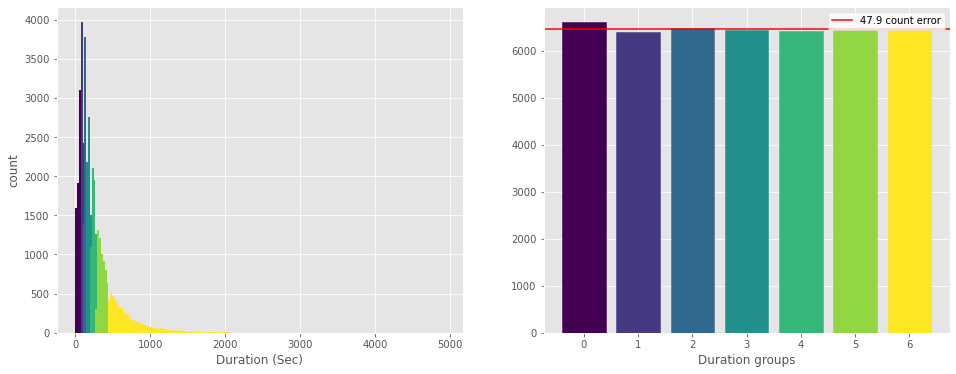

In [44]:
plot_num_qcut(df_bank_full, 'duration', xlabel='Duration (sec)', N=7)

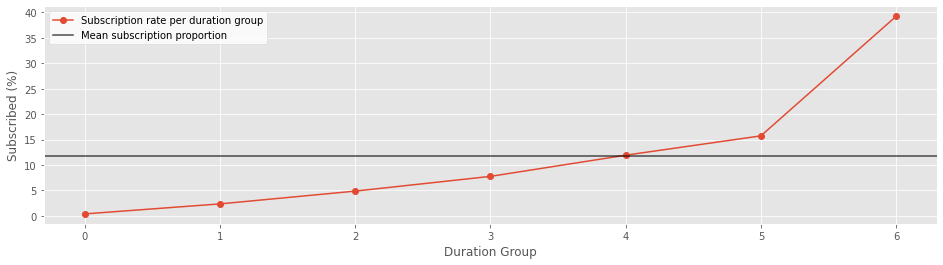

In [45]:
prob_plot(df_bank_full, 'duration', 7)

It seems that if customer had already subscribed to the deposit it is more likely that he will resign contract again.

### Campaign

* campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact).

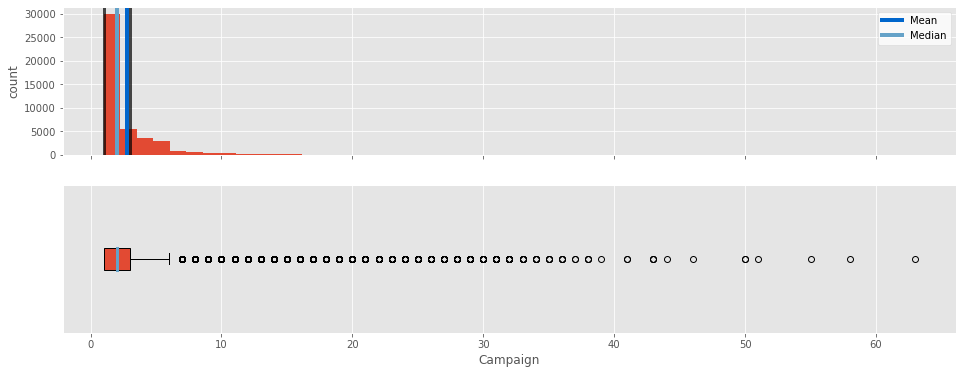

In [46]:
plot_num_dist(df_bank_full, 'campaign')

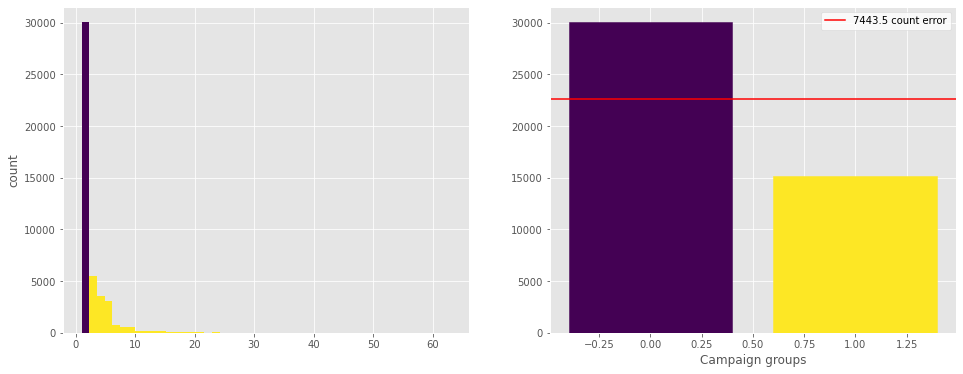

In [47]:
plot_num_qcut(df_bank_full, 'campaign', N=2)

In [48]:
# data is imbalanced, splitting into quantiles doesn't produce meaningful insights

# data is imbalanced, first 2 groups contain most of the data
df_bank_full['campaign'].value_counts().sort_index().head()

1    17544
2    12505
3     5521
4     3522
5     1764
Name: campaign, dtype: int64

In [49]:
# into 3 groups: 1 day, 2 days and >= 3 days since last contact

# temp DataFrame for quick calculations
_df = df_bank_full[['campaign', 'y']].copy()
_df.y.replace({'no': 0, 'yes': 1}, inplace=True)

# create new feature whatever customer was contacted or not
_df['campaign_split'] = _df.campaign.apply(lambda x: 0 if x == 1 else 1 if x == 2 else 2)

# 3 almost equaly sized groups
print('Each group represenet % of data')
(_df.campaign_split.value_counts()/len(_df)*100).sort_index().round(2)

Each group represenet % of data


0    38.80
1    27.66
2    33.54
Name: campaign_split, dtype: float64

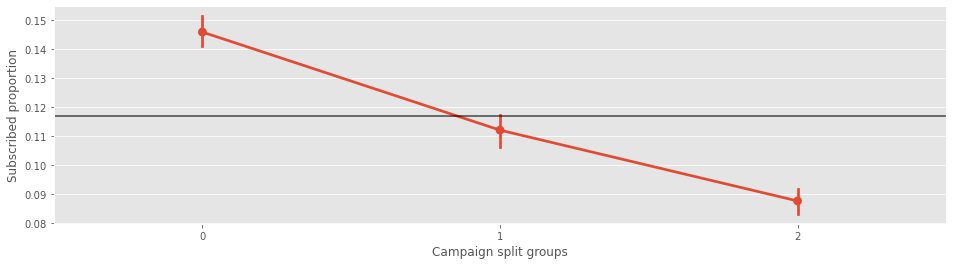

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
# Draw a nested barplot by species and sex
sns.pointplot(x="campaign_split", y="y", data=_df, dodge=True, ax=ax)
# horizontal line to show mean subscription rate per group
ax.axhline(_df['y'].mean(), color='k', alpha=0.7)
ax.set_ylabel('Subscribed proportion')
ax.set_xlabel('Campaign split groups');

### Pdays

* pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted).

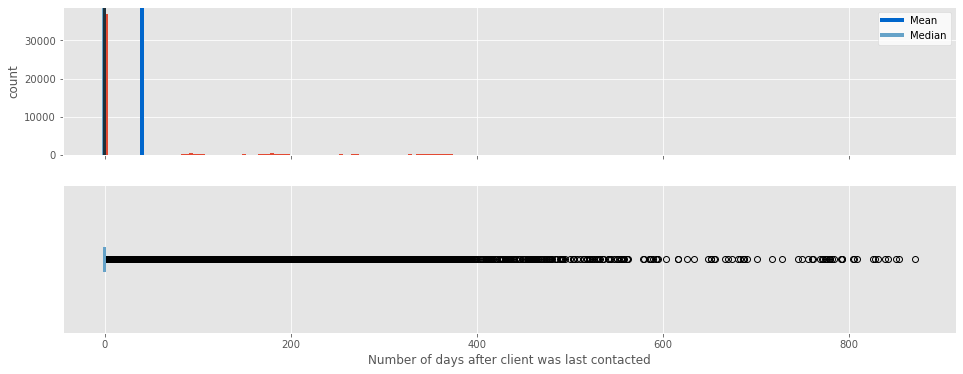

In [51]:
plot_num_dist(df_bank_full, 'pdays', 'Number of days after client was last contacted')

In [52]:
# data is imbalanced
ans = sum(df_bank_full['pdays'] == -1) / len(df_bank_full)

print(f'{ans*100:.1f}% data is pdays == -1, i.e. client was contacted for the first time.')

81.7% data is pdays == -1, i.e. client was contacted for the first time.


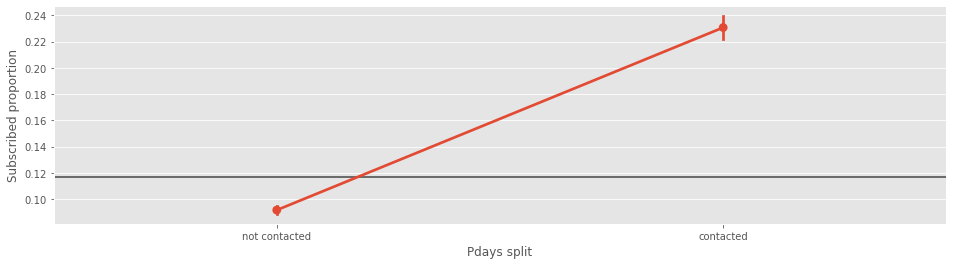

In [53]:
# temp DataFrame for quick calculations
_df = df_bank_full[['pdays', 'y']].copy()
_df.y.replace({'no': 0, 'yes': 1}, inplace=True)

# create new feature whatever customer was contacted or not
_df['pdays_split'] = (_df.pdays == -1).astype(int).replace({0: 'contacted', 1: 'not contacted'})

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
# horizontal line to show mean subscription rate per group
ax.axhline(_df['y'].mean(), color='k', alpha=0.7)
# Draw a nested barplot by species and sex
sns.pointplot(x="pdays_split", y="y", data=_df, dodge=True, ax=ax)
ax.set_ylabel('Subscribed proportion')
ax.set_xlabel('Pdays split');

While visualy it seems that people who were not contacted prior this campaign are less likely to sign contract one must remember that there are x4 times more people who were not contacted before, hence proportions can't be dirrectly compared.

### Previous

* previous: number of contacts performed before this campaign and for this client (numeric).

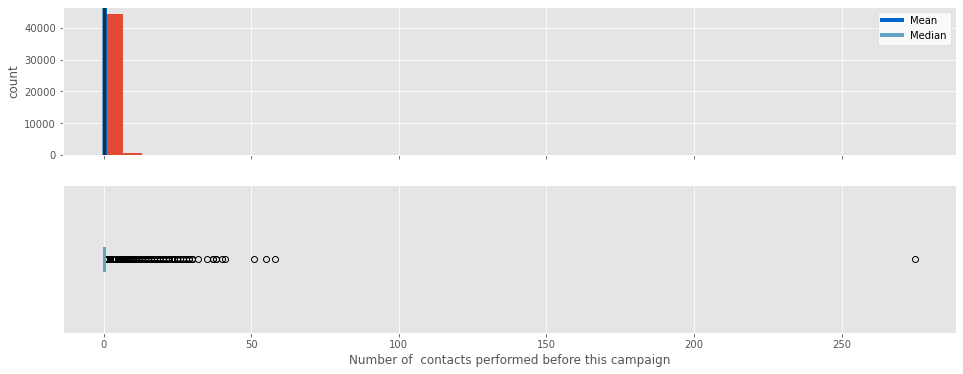

In [54]:
plot_num_dist(df_bank_full, 'previous', 'Number of  contacts performed before this campaign')

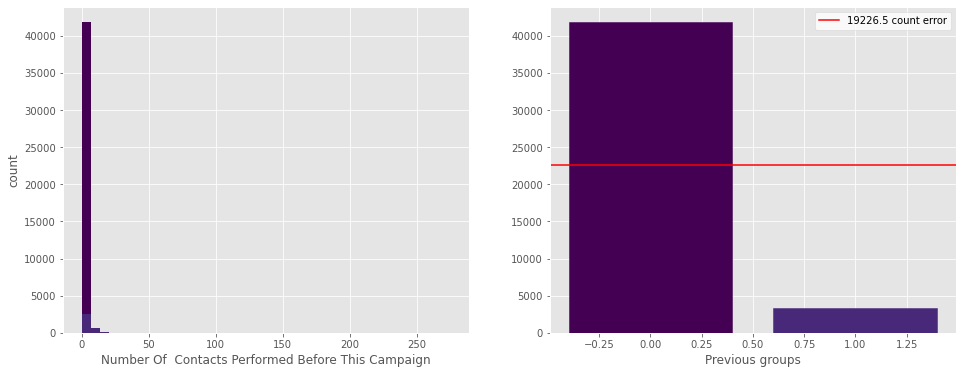

In [55]:
plot_num_qcut(df_bank_full, 'previous', 'Number of  contacts performed before this campaign', N=10)

In [56]:
# data is imbalanced, first group contains most of the data
df_bank_full['previous'].value_counts().sort_index().head()

0    36954
1     2772
2     2106
3     1142
4      714
Name: previous, dtype: int64

In [57]:
# into 3 groups: 1 day, 2 days and >= 3 days since last contact

# temp DataFrame for quick calculations
_df = df_bank_full[['pdays', 'previous', 'y']].copy()
_df.y.replace({'no': 0, 'yes': 1}, inplace=True)

# create new feature whatever customer was contacted or not
_df['previous_split'] = _df.previous.apply(lambda x: 0 if x == 0 else 1)

# 3 almost equaly sized groups
print('Each group represenet % of data')
(_df.previous_split.value_counts()/len(_df)*100).sort_index().round(2)

Each group represenet % of data


0    81.74
1    18.26
Name: previous_split, dtype: float64

In [58]:
# create new feature whatever customer was contacted or not
_df['pdays_split'] = (_df.pdays != -1).astype(int)
# basically same data as pdays
print('Each group represenet % of data')
(_df.pdays_split.value_counts()/len(_df)*100).sort_index().round(2)

Each group represenet % of data


0    81.74
1    18.26
Name: pdays_split, dtype: float64

In [59]:
# double check
# calculate counts of each segment
_cnts = _df[['previous_split', 'pdays_split', 'y']].pivot_table(index=['previous_split'], columns='pdays_split', aggfunc='count', fill_value=0)
_cnts

y      
pdays_split         0     1
previous_split             
0               36954     0
1                   0  8257

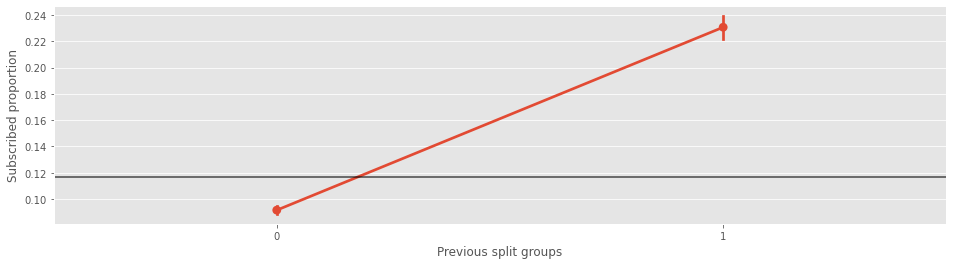

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
# Draw a nested barplot by species and sex
sns.pointplot(x="previous_split", y="y", data=_df, dodge=True, ax=ax)
# horizontal line to show mean subscription rate per group
ax.axhline(_df['y'].mean(), color='k', alpha=0.7)
ax.set_ylabel('Subscribed proportion')
ax.set_xlabel('Previous split groups');

People who are often contacted are less likely to subscribe.

## Categorical features
### Job

* type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services").

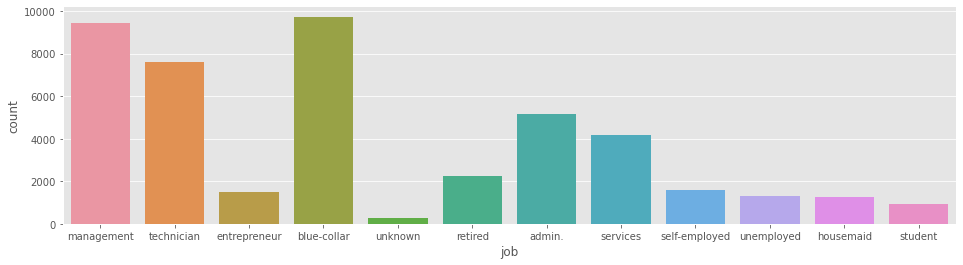

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax = sns.countplot(x="job", data=df_bank_full)

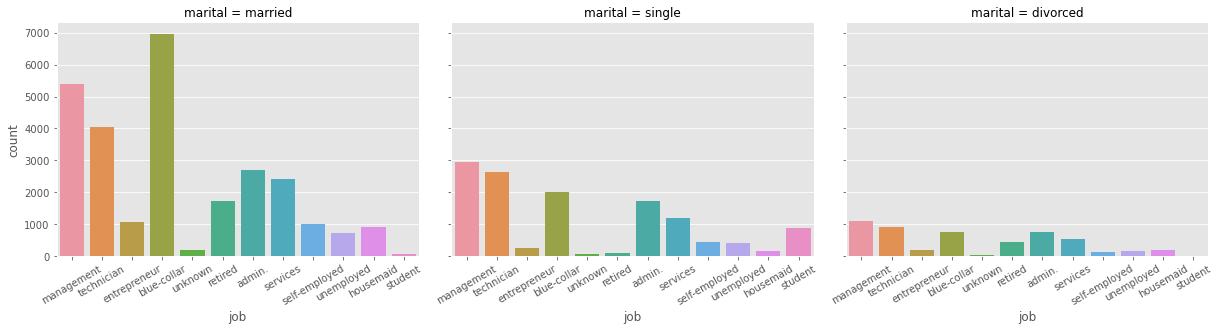

In [62]:
ax = sns.catplot(x="job", col="marital", data=df_bank_full, kind="count", height=4, aspect=1.4)
ax.set_xticklabels(rotation=30);

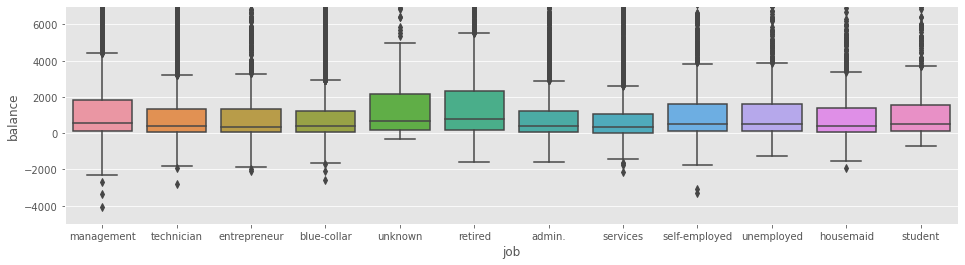

In [63]:
# investige jobs based on balance status, i.e. average yearly balance, in euros (numeric)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.boxplot(y='balance', x='job', ax=ax, data=df_bank_full)
# add custom y range limits
ax.set_ylim((-5000, 7000));

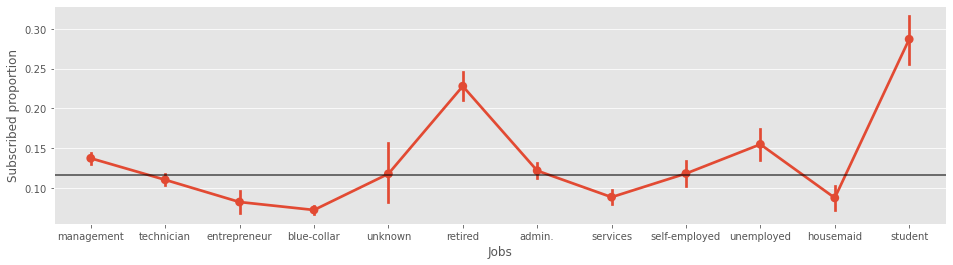

In [64]:
# temp DataFrame for quick calculations
_df = df_bank_full[['job', 'y']].copy()
_df.y.replace({'no': 0, 'yes': 1}, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

# Draw a nested barplot by species and sex
sns.pointplot(x="job", y="y", data=_df, dodge=True, ax=ax)

# horizontal line to show mean subscription rate per group
ax.axhline(_df['y'].mean(), color='k', alpha=0.7)
ax.set_ylabel('Subscribed proportion')
ax.set_xlabel('Jobs');

This confirms previously established observation: younger and older customers are more likely to subscribe.

### Marital

* marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed).

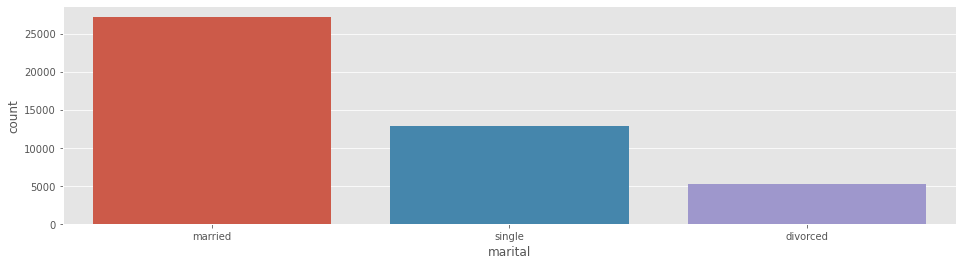

In [65]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax = sns.countplot(x="marital", data=df_bank_full)

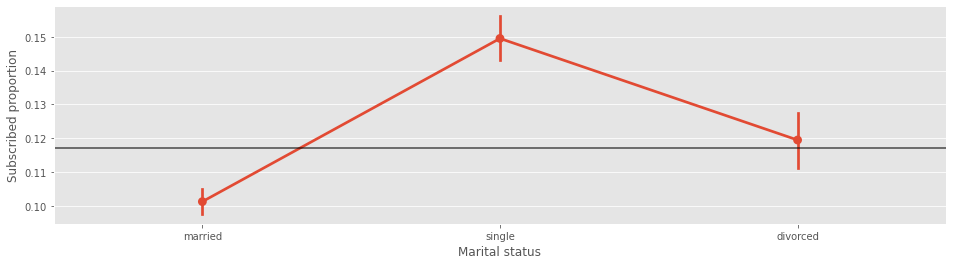

In [66]:
# temp DataFrame for quick calculations
_df = df_bank_full[['marital', 'y']].copy()
_df.y.replace({'no': 0, 'yes': 1}, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

# Draw a nested barplot by species and sex
sns.pointplot(x="marital", y="y", data=_df, dodge=True, ax=ax)

# horizontal line to show mean subscription rate per group
ax.axhline(_df['y'].mean(), color='k', alpha=0.7)
ax.set_ylabel('Subscribed proportion')
ax.set_xlabel('Marital status');

### Education

* education (categorical: "unknown","secondary","primary","tertiary").

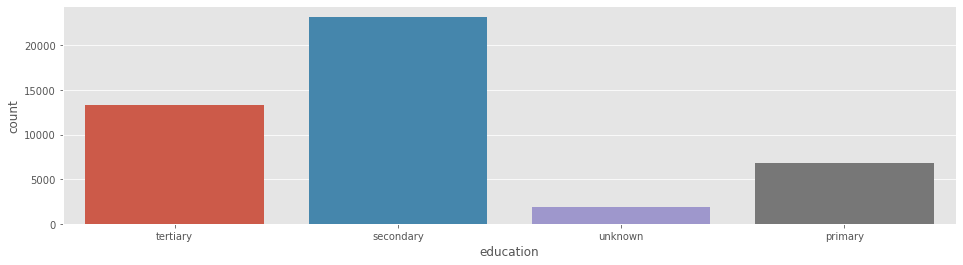

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax = sns.countplot(x="education", data=df_bank_full)

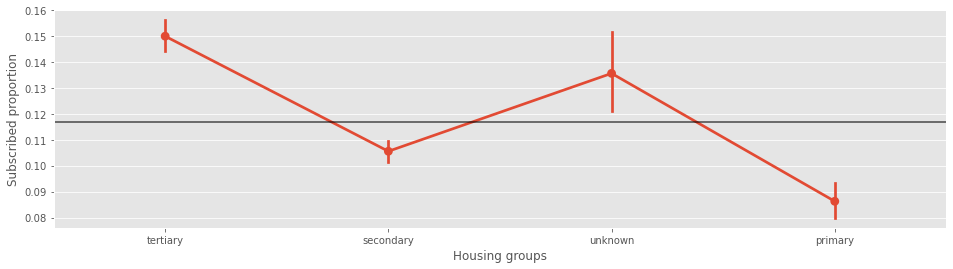

In [68]:
# temp DataFrame for quick calculations
_df = df_bank_full[['education', 'y']].copy()
_df.y.replace({'no': 0, 'yes': 1}, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

# Draw a nested barplot by species and sex
sns.pointplot(x="education", y="y", data=_df, dodge=True, ax=ax)

# horizontal line to show mean subscription rate per group
ax.axhline(_df['y'].mean(), color='k', alpha=0.7)
ax.set_ylabel('Subscribed proportion')
ax.set_xlabel('Housing groups');

### Default

* default: has credit in default? (binary: "yes","no").

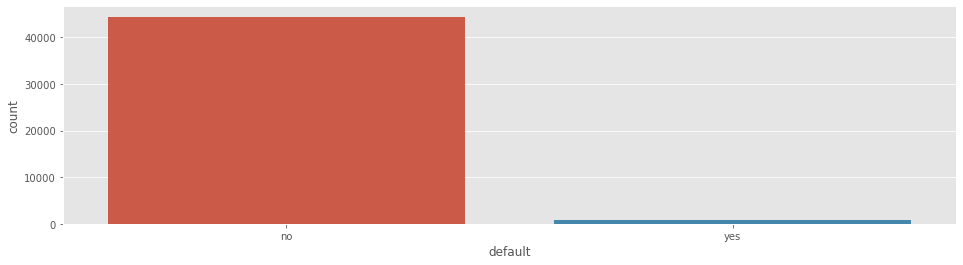

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax = sns.countplot(x="default", data=df_bank_full)

In [70]:
# extremelly imbalanced data
print(f'Reprensent (%) of all data')
(df_bank_full.default.value_counts()/len(df_bank_full)*100).round(2)

Reprensent (%) of all data


no     98.2
yes     1.8
Name: default, dtype: float64

In [71]:
df_bank_full.groupby('default')['y'].value_counts()

default  y  
no       no     39159
         yes     5237
yes      no       763
         yes       52
Name: y, dtype: int64

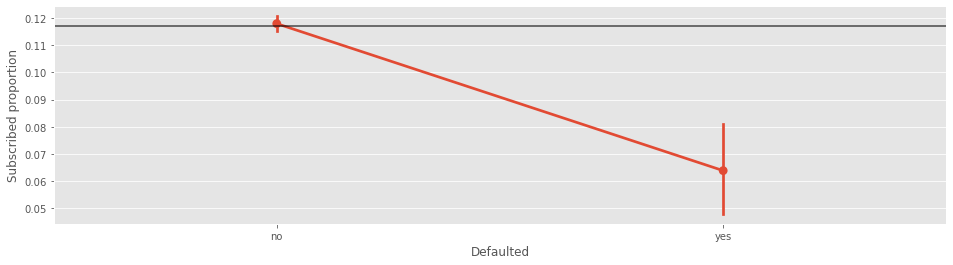

In [72]:
# temp DataFrame for quick calculations
_df = df_bank_full[['default', 'y']].copy()
_df.y.replace({'no': 0, 'yes': 1}, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))

# Draw a nested barplot by species and sex
sns.pointplot(x="default", y="y", data=_df, dodge=True, ax=ax)

# horizontal line to show mean subscription rate per group
ax.axhline(_df['y'].mean(), color='k', alpha=0.7)
ax.set_ylabel('Subscribed proportion')
ax.set_xlabel('Defaulted');

### Housing

* housing: has housing loan? (binary: "yes","no").

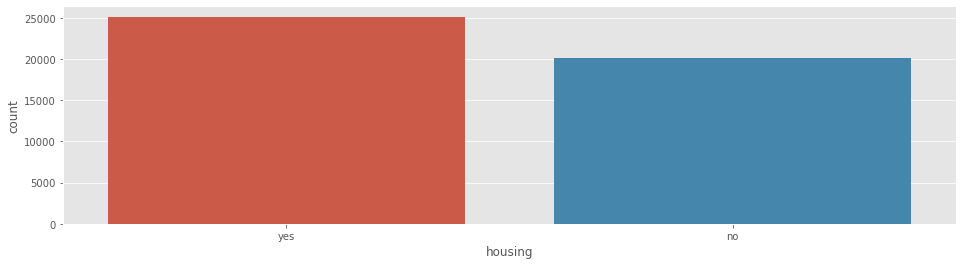

In [73]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax = sns.countplot(x="housing", data=df_bank_full)

In [74]:
# "similary" sized groups
df_bank_full['housing'].value_counts()

yes    25130
no     20081
Name: housing, dtype: int64

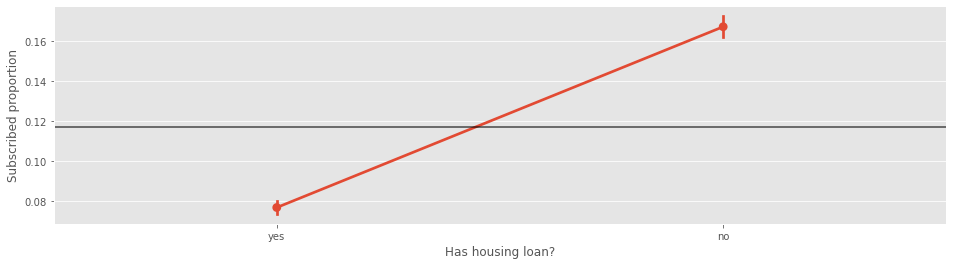

In [75]:
# temp DataFrame for quick calculations
_df = df_bank_full[['housing', 'y']].copy()
_df.y.replace({'no': 0, 'yes': 1}, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
# Draw a nested barplot by species and sex
sns.pointplot(x="housing", y="y", data=_df, dodge=True, ax=ax)
# horizontal line to show mean subscription rate per group
ax.axhline(_df['y'].mean(), color='k', alpha=0.7)
ax.set_ylabel('Subscribed proportion')
ax.set_xlabel('Has housing loan?');

Seems that people **without** housing loans are more likely to subscribe for long term deposit.

### Loan

* loan: has personal loan? (binary: "yes","no").

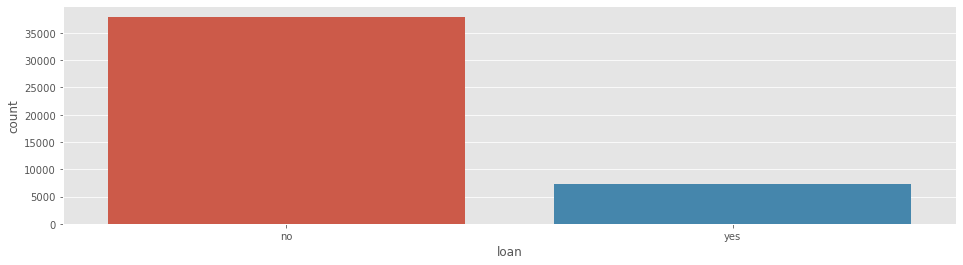

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax = sns.countplot(x="loan", data=df_bank_full)

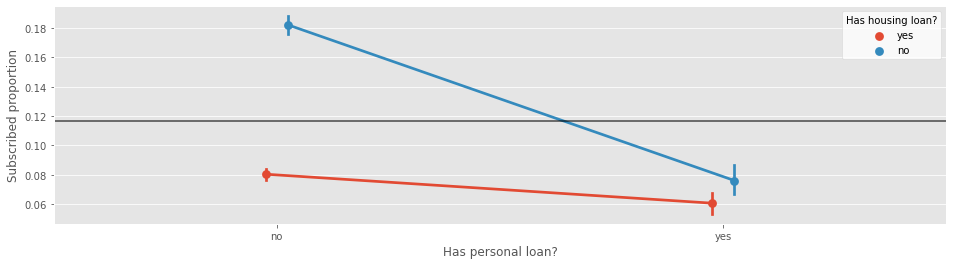

In [77]:
# investigate proportions of how many people have both housing and personal loans

# temp DataFrame for quick calculations
_df = df_bank_full[['loan', 'housing', 'y']].copy()
_df.y.replace({'no': 0, 'yes': 1}, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(16, 4))
# Draw a nested barplot by species and sex
sns.pointplot(x="loan", y="y", hue='housing', data=_df, dodge=True, ax=ax)
# horizontal line to show mean subscription rate per group
ax.axhline(_df['y'].mean(), color='k', alpha=0.7)
ax.set_ylabel('Subscribed proportion')
ax.set_xlabel('Has personal loan?')

# add legend with white background
legend = ax.legend(frameon=1, title='Has housing loan?')
frame = legend.get_frame()
frame.set_facecolor('w')

In [78]:
# calculate counts of each segment
_cnts = _df.pivot_table(index=['loan'], columns='housing', aggfunc='count', fill_value=0)
# calculate proportions and multiply by 100 to convert to percentages
_cnts.loc[:] = _cnts / len(_df)
# rename columns
_cnts.columns = [_[1] for _ in _cnts.columns]
_cnts

,no,yes
loan,,
no,0.380527,0.459247
yes,0.063635,0.096592


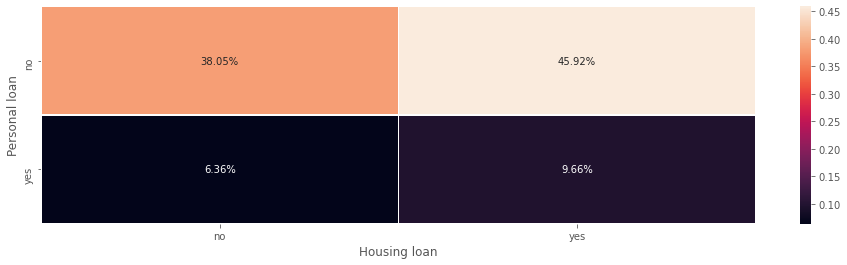

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
sns.heatmap(_cnts, annot=True, linewidths=.5, fmt=".2%", ax=ax)
ax.set_ylabel('Personal loan');
ax.set_xlabel('Housing loan');

It seems that having no loans increases probability that customer with subscribe to long term deposit. That being said, only 6.36% of all customers fall into category no loans.

### Contact

* contact: contact communication type (categorical: "unknown","telephone","cellular").

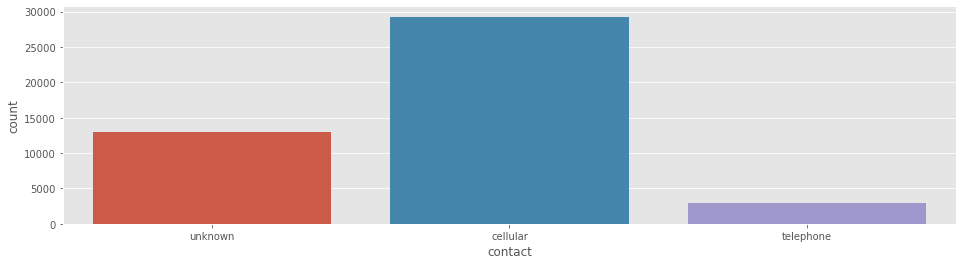

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax = sns.countplot(x="contact", data=df_bank_full)

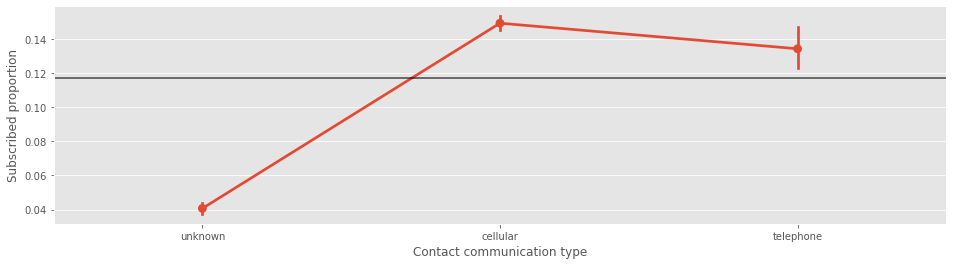

In [81]:
# temp DataFrame for quick calculations
_df = df_bank_full[['contact', 'y']].copy()
_df.y.replace({'no': 0, 'yes': 1}, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
# Draw a nested barplot by species and sex
sns.pointplot(x="contact", y="y", data=_df, dodge=True, ax=ax)
# horizontal line to show mean subscription rate per group
ax.axhline(_df['y'].mean(), color='k', alpha=0.7)
ax.set_ylabel('Subscribed proportion')
ax.set_xlabel('Contact communication type');

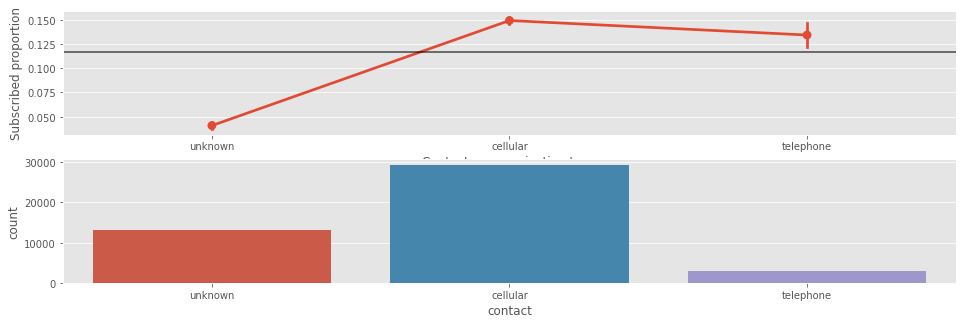

In [82]:
fig, ax = plt.subplots(2, 1, figsize=(16, 5))
# Draw a nested barplot by species and sex
sns.pointplot(x="contact", y="y", data=_df, dodge=True, ax=ax[0])
sns.countplot(x="contact", data=_df, ax=ax[1])
# horizontal line to show mean subscription rate per group
ax[0].axhline(_df['y'].mean(), color='k', alpha=0.7)
ax[0].set_ylabel('Subscribed proportion')
ax[0].set_xlabel('Contact communication type');

### Month

* month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec").

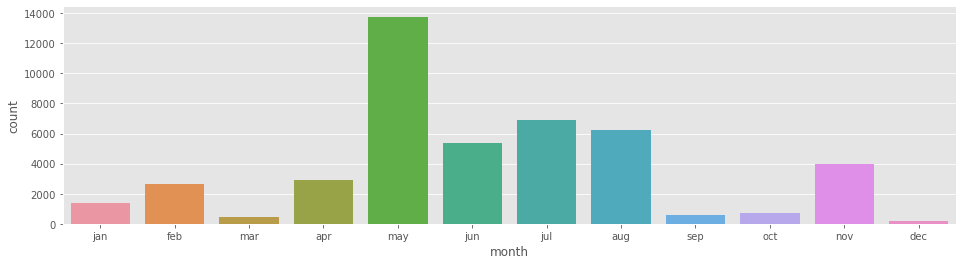

In [83]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax = sns.countplot(x="month", data=df_bank_full, order=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])

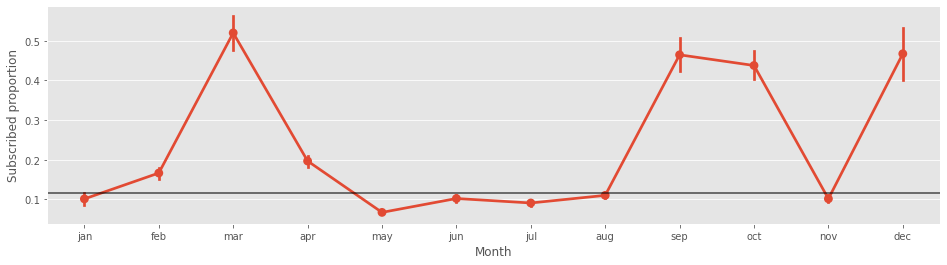

In [84]:
# temp DataFrame for quick calculations
_df = df_bank_full[['month', 'y']].copy()
_df.y.replace({'no': 0, 'yes': 1}, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
# Draw a nested barplot by species and sex
sns.pointplot(x="month", y="y", data=_df, dodge=True, ax=ax,
              order=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
# horizontal line to show mean subscription rate per group
ax.axhline(_df['y'].mean(), color='k', alpha=0.7)
ax.set_ylabel('Subscribed proportion')
ax.set_xlabel('Month');

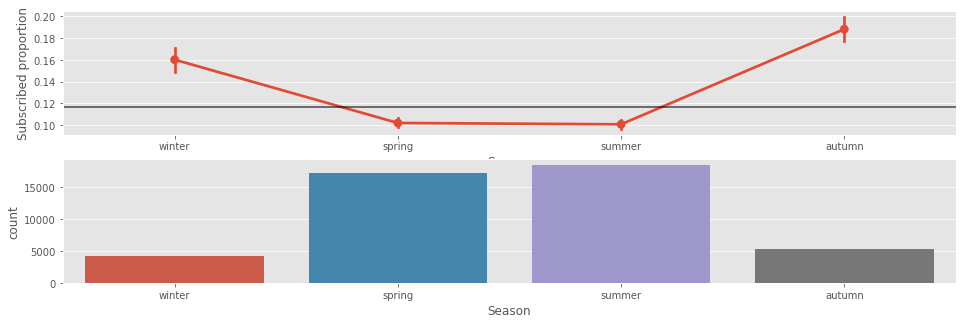

In [85]:
# group months into seasons: spring, summer, autumn and winter
season_dict = {'jan': 'winter', 'feb': 'winter', 'mar': 'spring', 'apr': 'spring', 'may': 'spring',
               'jun': 'summer', 'jul': 'summer', 'aug': 'summer', 'sep': 'autumn', 'oct': 'autumn', 'nov': 'autumn', 'dec': 'winter'}
_df['Season'] = _df['month'].apply(lambda x: season_dict[x])


fig, ax = plt.subplots(2, 1, figsize=(16, 5))
# Draw a nested barplot by species and sex
sns.pointplot(x="Season", y="y", data=_df, dodge=True, ax=ax[0], order=['winter', 'spring', 'summer', 'autumn'])
sns.countplot(x="Season", data=_df, ax=ax[1], order=['winter', 'spring', 'summer', 'autumn'])
# horizontal line to show mean subscription rate per group
ax[0].axhline(_df['y'].mean(), color='k', alpha=0.7)
ax[0].set_ylabel('Subscribed proportion')
ax[0].set_xlabel('Season');

### Poutcome

* poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success").

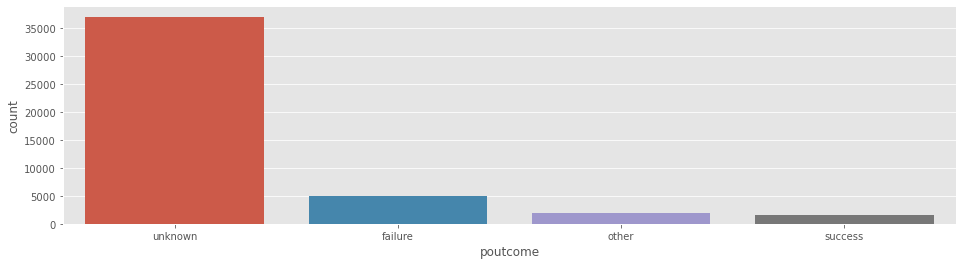

In [86]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax = sns.countplot(x="poutcome", data=df_bank_full)

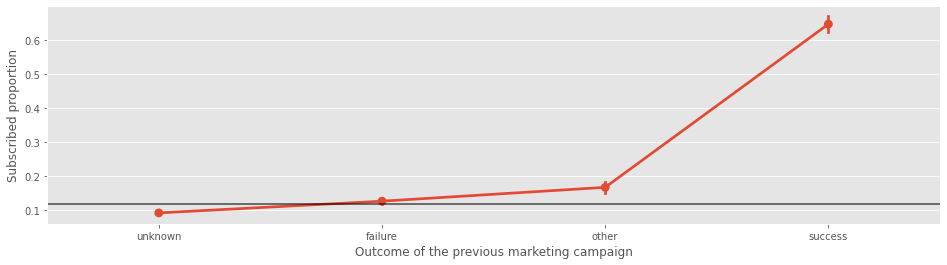

In [87]:
# temp DataFrame for quick calculations
_df = df_bank_full[['poutcome', 'y']].copy()
_df.y.replace({'no': 0, 'yes': 1}, inplace=True)
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
# Draw a nested barplot by species and sex
sns.pointplot(x="poutcome", y="y", data=_df, dodge=True, ax=ax)
# horizontal line to show mean subscription rate per group
ax.axhline(_df['y'].mean(), color='k', alpha=0.7)
ax.set_ylabel('Subscribed proportion')
ax.set_xlabel('Outcome of the previous marketing campaign');

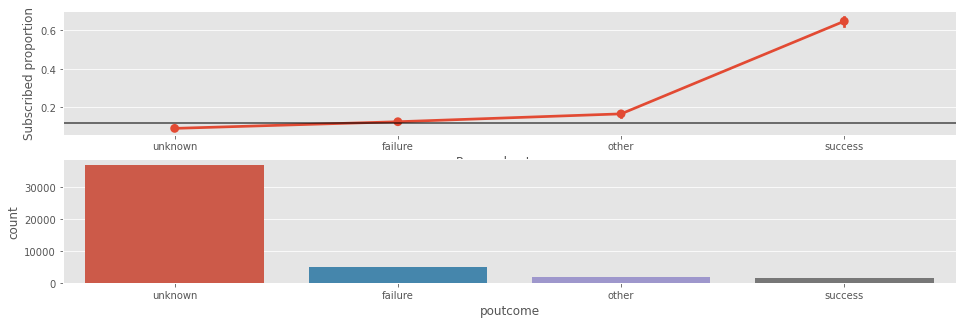

In [88]:
fig, ax = plt.subplots(2, 1, figsize=(16, 5))
# Draw a nested barplot by species and sex
sns.pointplot(x="poutcome", y="y", data=_df, dodge=True, ax=ax[0])
sns.countplot(x="poutcome", data=_df, ax=ax[1])
# horizontal line to show mean subscription rate per group
ax[0].axhline(_df['y'].mean(), color='k', alpha=0.7)
ax[0].set_ylabel('Subscribed proportion')
ax[0].set_xlabel('Proposal outcome');

# MODELLING TASK

In [89]:
# rename DataFrames for ML

# all train features
X = df_bank_full.iloc[:, :-1].copy()
# target
y = df_bank_full['y'].map({'yes' : 1, 'no' : 0})

## Feature transformation

In [90]:
def transform_df(df, col_names):
    """
    This function transforms data for ML model.
    Transformations will be applied only on selected columns
    :param df: pandas DataFrame 
    :param col_names: list of columns to select from DataFrame 
    :return: pandas DataFrame
    """
    # select specific features
    df = df[col_names].copy()
    
    # 1 - age (numeric)
    if 'age' in df.columns:
        # cut age into 10 deciles and convert to string for one-hot-encoding (OHE)
        df['age'] = pd.qcut(df['age'], 10, duplicates='drop', labels=False).astype(str)
        # one-hot-encode feature
        df = pd.concat([df, pd.get_dummies(df['age'], prefix='age', drop_first=True)], axis=1) 
        # delete age column
        del df['age']
        
    # 2 - job
    if 'job' in df.columns:
        # OHE
        df = pd.concat([df, pd.get_dummies(df['job'], prefix='job', drop_first=True)], axis=1) 
        # delete job column
        del df['job']
    
    # 3 - marital
    if 'marital' in df.columns:
        # OHE
        df = pd.concat([df, pd.get_dummies(df['marital'], prefix='marital', drop_first=True)], axis=1) 
        # delete marital column
        del df['marital']
    
    # 4 - education
    if 'education' in df.columns:
        # OHE
        df = pd.concat([df, pd.get_dummies(df['education'], prefix='education', drop_first=True)], axis=1) 
        # delete education column
        del df['education']
    
    # 5 - default
    if 'default' in df.columns:
        # convert text to integers
        df['default'] = df['default'].map({'no': 0, 'yes': 1})
    
    # 6 - balance
    if 'balance' in df.columns:
        # cut balance into 6 quantiles
        df['balance'] = pd.qcut(df['balance'], 6, duplicates='drop', labels=False)
        # min-max scale feature
        df['balance'] = df['balance'] / 5
    
    # 7 - housing
    if 'housing' in df.columns:
        # convert text to integers
        df['housing'] = df['housing'].map({'no': 0, 'yes': 1})
    
    # 8 - loan
    if 'loan' in df.columns:
        # convert text to integers
        df['loan'] = df['loan'].map({'no': 0, 'yes': 1})
         
    # 9 - contact
    if 'contact' in df.columns:
        # OHE
        df = pd.concat([df, pd.get_dummies(df['contact'], prefix='contact', drop_first=True)], axis=1)
        # delete contact column
        del df['contact']
    
    # 10 - day
    if 'day' in df.columns:
        # from visual analysis no meaningful patern was established, so I will aply min-max transformation
        df['day'] = (df['day']-df['day'].min()) / (df['day'].max() - df['day'].min())
    
    # 11 - month
    if 'month' in df.columns:
        # create new feature season: spring, summer, autumn and winter
        season_dict = {'jan': 'winter', 'feb': 'winter', 'mar': 'spring', 'apr': 'spring', 'may': 'spring',
                       'jun': 'summer', 'jul': 'summer', 'aug': 'summer', 'sep': 'autumn',
                       'oct': 'autumn', 'nov': 'autumn', 'dec': 'winter'}
        df['season'] = df['month'].apply(lambda x: season_dict[x])
        # OHE
        df = pd.concat([df, pd.get_dummies(df['season'], prefix='season', drop_first=True)], axis=1)
        df = pd.concat([df, pd.get_dummies(df['month'], prefix='month', drop_first=True)], axis=1)
        # delete month and season columns
        df.drop(['month', 'season'], axis=1, inplace=True)
    
    # 12 - duration
    if 'duration' in df.columns:
        # cut duration into 7 quantiles and convert to string for one-hot-encoding (OHE)
        df['duration'] = pd.qcut(df['duration'], 7, duplicates='drop', labels=False).astype(str)
        # one-hot-encode feature
        df = pd.concat([df, pd.get_dummies(df['duration'], prefix='duration', drop_first=True)], axis=1) 
        # delete duration column
        del df['duration']
    
    # 13 - campaign
    if 'campaign' in df.columns:
        # group into 3 groups: 1 day, 2 days and >= 3 days since last contact
        # create new feature whatever customer was contacted. Convert to string for OHE
        df['campaign'] = df['campaign'].apply(lambda x: 0 if x == 1 else 1 if x == 2 else 2).astype(str)
        # one-hot-encode feature
        df = pd.concat([df, pd.get_dummies(df['campaign'], prefix='campaign', drop_first=True)], axis=1) 
        # delete campaign column
        del df['campaign']
    
    # 14 - pdays
    if 'pdays' in df.columns:
        # create new feature whatever customer was contacted (1) or not (0)
        df['pdays'] = (df['pdays'] != -1).astype(int)
    
    # 15 - previous
    if 'previous' in df.columns:
        # previous is same feature as pdays, for this reason drop this feature
        del df['previous']

    # 16 - poutcome
    if 'poutcome' in df.columns:
        # OHE
        df = pd.concat([df, pd.get_dummies(df['poutcome'], prefix='poutcome', drop_first=True)], axis=1)
        # delete poutcome column
        del df['poutcome']
    
    return df

In [91]:
# transform all data
X_transformed = transform_df(X, X.columns)

# split raw-data into train and test sub-sets, 70/30 ratio
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X, y,
                                                                    test_size=0.3, random_state=RANDOM_STATE)

# split transformed-data into train and test sub-sets, 70/30 ratio
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.3, random_state=RANDOM_STATE)

## Baseline predictions

![wiki example](https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/320px-Precisionrecall.svg.png)

3 metrics will be used to evaluate model:

* accuracy,
* prediction,
* recall.

### Naive prediction

Let's contact all customers and caculate metrics.

In [92]:
# send promotions to all customers
pred_naive = np.ones(len(X))
print('Contact all customers, prediction for all data')

# calculate baseline accuracy, precision and recall
_accuracy = accuracy_score(y, pred_naive)
_recall = recall_score(y, pred_naive) 
_precision = precision_score(y, pred_naive)
_f1 = f1_score(y, pred_naive)

print(f'Accuracy:  {_accuracy:.3f}')
print(f'Precision: {_precision:.3f}')
print(f'Recall:    {_recall:.3f}')
print(f'F-1:       {_f1:.3f}')

Contact all customers, prediction for all data
Accuracy:  0.117
Precision: 0.117
Recall:    1.000
F-1:       0.209


Let's make `naive` prediction based on visual data analysis in part 2. We will send promotions for long-term deposits to people who satisfy one of the following conditions bellow:

* people in 1-st and last age deciles,
* people who don't have neither housing nor personal loan,
* people with account balance above sample median.

In [93]:
# People in 1-st and last age deciles
cond_1 = pd.qcut(X['age'], 10, duplicates='drop', labels=False).isin([0, 9])
# people who don't have neither housing nor personal loan,
cond_2 = (X['housing'] == 'no') & (X['loan'] == 'no') 
# people with account balance above sample median
cond_3 = (X.balance >= X.balance.median()).astype(int)

# send promotions if atleast 1 condition is satisfied
pred_naive = (cond_1 | cond_2 | cond_3).astype(int)
print('Naive prediction for all data')

# calculate baseline accuracy, precision and recall
_accuracy = accuracy_score(y, pred_naive)
_recall = recall_score(y, pred_naive) 
_precision = precision_score(y, pred_naive)
_f1 = f1_score(y, pred_naive)

print(f'Accuracy:  {_accuracy:.3f}')
print(f'Precision: {_precision:.3f}')
print(f'Recall:    {_recall:.3f}')
print(f'F-1:       {_f1:.3f}')

Naive prediction for all data
Accuracy:  0.352
Precision: 0.137
Recall:    0.859
F-1:       0.237


In [94]:
# test baseline prediction on test sub-sample

# People in 1-st and last age deciles
cond_1 = pd.qcut(X_test_raw['age'], 10, duplicates='drop', labels=False).isin([0, 9])
# people who don't have neither housing nor personal loan,
cond_2 = (X_test_raw['housing'] == 'no') & (X_test_raw['loan'] == 'no') 
# people with account balance above sample median
cond_3 = (X_test_raw.balance >= X.balance.median()).astype(int)

# send promotions if atleast 1 condition is satisfied
pred_naive_test = (cond_1 | cond_2 | cond_3).astype(int)
print('Naive prediction for all data')

# # calculate baseline accuracy, precision and recall
_accuracy = accuracy_score(y_test_raw, pred_naive_test)
_recall = recall_score(y_test_raw, pred_naive_test) 
_precision = precision_score(y_test_raw, pred_naive_test)
_f1 = f1_score(y_test_raw, pred_naive_test)

print(f'Accuracy:  {_accuracy:.3f}')
print(f'Precision: {_precision:.3f}')
print(f'Recall:    {_recall:.3f}')
print(f'F-1:       {_f1:.3f}')

Naive prediction for all data
Accuracy:  0.354
Precision: 0.139
Recall:    0.865
F-1:       0.240


In [95]:
print(f'Our naive prediction model on test sub-set produced similiar prediction metrics.')

Our naive prediction model on test sub-set produced similiar prediction metrics.


### Naive Bayes

Before impleting Logistic regression or other ML models, I always test naive Baysian model for baseline metrics.

In [96]:
from sklearn.naive_bayes import GaussianNB

In [97]:
# create baysian classifier
bayes_clf = GaussianNB()
# fit on all data
bayes_clf.fit(X_transformed, y)
# predictions for all data
pred_nb = bayes_clf.predict(X_transformed)

print('Naive Bayes Classifier prediction for all data')

# # calculate baseline accuracy, precision and recall
_accuracy = accuracy_score(pred_nb, y)
_recall = recall_score(pred_nb, y) 
_precision = precision_score(pred_nb, y)
_f1 = f1_score(pred_nb, y)

print(f'Accuracy:  {_accuracy:.3f}')
print(f'Precision: {_precision:.3f}')
print(f'Recall:    {_recall:.3f}')
print(f'F-1:       {_f1:.3f}')

Naive Bayes Classifier prediction for all data
Accuracy:  0.855
Precision: 0.467
Recall:    0.399
F-1:       0.430


In [98]:
# train only on train dataset and then test predictions on test sub-set

# create baysian classifier
bayes_clf = GaussianNB()
# fit on all data
bayes_clf.fit(X_train, y_train)
# predictions for all data
pred_nb_test = bayes_clf.predict(X_test)

print('Naive Bayes Classifier predictions for test data')

# # calculate baseline accuracy, precision and recall
_accuracy = accuracy_score(pred_nb_test, y_test)
_recall = recall_score(pred_nb_test, y_test) 
_precision = precision_score(pred_nb_test, y_test)
_f1 = f1_score(pred_nb_test, y_test)

print(f'Accuracy:  {_accuracy:.3f}')
print(f'Precision: {_precision:.3f}')
print(f'Recall:    {_recall:.3f}')
print(f'F-1:       {_f1:.3f}')

Naive Bayes Classifier predictions for test data
Accuracy:  0.855
Precision: 0.472
Recall:    0.402
F-1:       0.434


## Logistic regression

### Single best feature selection

Best features will be selected using K-fold cross-validation technique.

In [99]:
# previous feature is droped from analysis because it encodes same information as pdays
features = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan',
            'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'poutcome']

# create empty DataFrame to store cross-validation results
df_feat_compare = pd.DataFrame()

# list of scorring metrics
scoring = {'accuracy': 'accuracy', 'recall': 'recall', 'brier_score': 'neg_brier_score', "F1": 'f1'}

# create cross-validation split object
cv_split = ShuffleSplit(n_splits=10, test_size=.3, train_size=.7, random_state=RANDOM_STATE)

for i, feature in enumerate(features):
    # transform data only for specific feature
    _X = transform_df(X, [feature])    
    
    # select rows from train sub-set (see Feature transformatio section above)
    _X = _X.loc[X_train.index]
    
    # create logistic Regression classifier
    lr_clf = LogisticRegression(random_state=RANDOM_STATE)
    
    # cross-validate results
    cv_results = cross_validate(lr_clf, _X, y_train, cv= cv_split, scoring = scoring, return_train_score=True)
    
    # add feature name
    df_feat_compare.loc[i, 'feature_name'] = feature
    
    # record cross-validation results
    for _key in cv_results.keys():
        df_feat_compare.loc[i, _key+'_mean'] = cv_results[_key].mean()
        df_feat_compare.loc[i, _key+'_std'] = cv_results[_key].std()

#### Best features

In [100]:
# get Top 5 most stable features (lowest accuracy standard deviation)
df_feat_compare.sort_values(by='test_accuracy_std')[['feature_name', 'test_accuracy_std', 'test_accuracy_mean',
                                                     'test_recall_mean', 'test_brier_score_mean', 'test_F1_mean']].head()

,feature_name,test_accuracy_std,test_accuracy_mean,test_recall_mean,test_brier_score_mean,test_F1_mean
14,poutcome,0.001453,0.893555,0.182820,-0.092759,0.28497
10,month,0.002464,0.883770,0.017464,-0.095609,0.03202
0,age,0.002541,0.883928,0.000000,-0.101364,0.00000
1,job,0.002541,0.883928,0.000000,-0.100800,0.00000
2,marital,0.002541,0.883928,0.000000,-0.102220,0.00000


In [101]:
# best results by recall metric
df_feat_compare.sort_values(by='test_recall_mean')[['feature_name', 'test_accuracy_mean',
                                                    'test_recall_mean', 'test_brier_score_mean', 'test_F1_mean']].tail()

,feature_name,test_accuracy_mean,test_recall_mean,test_brier_score_mean,test_F1_mean
11,duration,0.883928,0.000000,-0.087868,0.00000
12,campaign,0.883928,0.000000,-0.102106,0.00000
13,pdays,0.883928,0.000000,-0.099718,0.00000
10,month,0.883770,0.017464,-0.095609,0.03202
14,poutcome,0.893555,0.182820,-0.092759,0.28497


In [102]:
# best results by brier score
df_feat_compare.sort_values(by='test_brier_score_mean')[['feature_name', 'test_accuracy_mean',
                                                         'test_recall_mean', 'test_brier_score_mean', 'test_F1_mean']].tail()

,feature_name,test_accuracy_mean,test_recall_mean,test_brier_score_mean,test_F1_mean
8,contact,0.883928,0.000000,-0.100186,0.00000
13,pdays,0.883928,0.000000,-0.099718,0.00000
10,month,0.883770,0.017464,-0.095609,0.03202
14,poutcome,0.893555,0.182820,-0.092759,0.28497
11,duration,0.883928,0.000000,-0.087868,0.00000


In [103]:
# best results by F-1 score
df_feat_compare.sort_values(by='test_F1_mean')[['feature_name', 'test_accuracy_mean',
                                                'test_recall_mean', 'test_brier_score_mean', 'test_F1_mean']].tail()

,feature_name,test_accuracy_mean,test_recall_mean,test_brier_score_mean,test_F1_mean
11,duration,0.883928,0.000000,-0.087868,0.00000
12,campaign,0.883928,0.000000,-0.102106,0.00000
13,pdays,0.883928,0.000000,-0.099718,0.00000
10,month,0.883770,0.017464,-0.095609,0.03202
14,poutcome,0.893555,0.182820,-0.092759,0.28497


#### Worst features

In [104]:
# get Top 5 most unpredictable features (highest accuracy standard deviation)
df_feat_compare.sort_values(by='test_accuracy_std')[['feature_name', 'test_accuracy_std', 'test_accuracy_mean',
                                                     'test_recall_mean', 'test_brier_score_mean', 'test_F1_mean']].tail()

,feature_name,test_accuracy_std,test_accuracy_mean,test_recall_mean,test_brier_score_mean,test_F1_mean
8,contact,0.002541,0.883928,0.0,-0.100186,0.0
9,day,0.002541,0.883928,0.0,-0.102553,0.0
11,duration,0.002541,0.883928,0.0,-0.087868,0.0
12,campaign,0.002541,0.883928,0.0,-0.102106,0.0
13,pdays,0.002541,0.883928,0.0,-0.099718,0.0


In [105]:
# worst results by accuracy metric
df_feat_compare.sort_values(by='test_accuracy_mean')[['feature_name', 'test_accuracy_mean',
                                                    'test_recall_mean', 'test_brier_score_mean', 'test_F1_mean']].head()

,feature_name,test_accuracy_mean,test_recall_mean,test_brier_score_mean,test_F1_mean
10,month,0.883770,0.017464,-0.095609,0.03202
0,age,0.883928,0.000000,-0.101364,0.00000
1,job,0.883928,0.000000,-0.100800,0.00000
2,marital,0.883928,0.000000,-0.102220,0.00000
3,education,0.883928,0.000000,-0.102146,0.00000


In [106]:
# worst results by brier score metric
df_feat_compare.sort_values(by='test_brier_score_mean')[['feature_name', 'test_accuracy_mean',
                                                    'test_recall_mean', 'test_brier_score_mean', 'test_F1_mean']].head()

,feature_name,test_accuracy_mean,test_recall_mean,test_brier_score_mean,test_F1_mean
4,default,0.883928,0.0,-0.102579,0.0
9,day,0.883928,0.0,-0.102553,0.0
2,marital,0.883928,0.0,-0.102220,0.0
3,education,0.883928,0.0,-0.102146,0.0
7,loan,0.883928,0.0,-0.102134,0.0


In [107]:
# worst results by F-1 score
df_feat_compare.sort_values(by='test_F1_mean')[['feature_name', 'test_accuracy_mean',
                                                'test_recall_mean', 'test_brier_score_mean', 'test_F1_mean']].head()

,feature_name,test_accuracy_mean,test_recall_mean,test_brier_score_mean,test_F1_mean
0,age,0.883928,0.0,-0.101364,0.0
1,job,0.883928,0.0,-0.100800,0.0
2,marital,0.883928,0.0,-0.102220,0.0
3,education,0.883928,0.0,-0.102146,0.0
4,default,0.883928,0.0,-0.102579,0.0


### Pair of features selection

Combinations of 2 best features will be select and tested using K-fold validation technique.

In [108]:
# previous feature is droped from analysis because it encodes same information as pdays
features = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan',
            'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'poutcome']

# generate available combiantions of features
features = [_ for _ in combinations(features, 2)]

# create empty DataFrame to store cross-validation results
df_feat_compare = pd.DataFrame()

# list of scorring metrics
scoring = {'accuracy': 'accuracy', 'recall': 'recall', 'brier_score': 'neg_brier_score', "F1": 'f1'}

# create cross-validation split object
cv_split = ShuffleSplit(n_splits=10, test_size=.3, train_size=.7, random_state=RANDOM_STATE)

for i, feature in enumerate(features):
    # transform data only for specific feature
    _X = transform_df(X, list(feature))    
    
    # select rows from train sub-set (see Feature transformatio section above)
    _X = _X.loc[X_train.index]
    
    # create logistic Regression classifier
    lr_clf = LogisticRegression(random_state=RANDOM_STATE)
    
    # cross-validate results
    cv_results = cross_validate(lr_clf, _X, y_train, cv= cv_split, scoring = scoring, return_train_score=True)
    
    # add feature name
    df_feat_compare.loc[i, 'feature_name_1'] = feature[0]
    df_feat_compare.loc[i, 'feature_name_2'] = feature[1]
    
    # record cross-validation results
    for _key in cv_results.keys():
        df_feat_compare.loc[i, _key+'_mean'] = cv_results[_key].mean()
        df_feat_compare.loc[i, _key+'_std'] = cv_results[_key].std()

#### Best features

In [109]:
# get Top 5 most stable features (lowest accuracy standard deviation)
df_feat_compare.sort_values(by='test_accuracy_std')[['feature_name_1', 'feature_name_2', 'test_accuracy_mean',
                                                     'test_recall_mean', 'test_brier_score_mean', 'test_F1_mean']].head()

,feature_name_1,feature_name_2,test_accuracy_mean,test_recall_mean,test_brier_score_mean,test_F1_mean
101,duration,poutcome,0.895650,0.185104,-0.078556,0.291597
26,job,poutcome,0.893418,0.181137,-0.091639,0.282855
89,contact,poutcome,0.893691,0.182363,-0.091507,0.284719
38,marital,poutcome,0.893555,0.182820,-0.092572,0.284970
94,day,poutcome,0.893555,0.182820,-0.092772,0.284970


In [110]:
# best results by recall metric
df_feat_compare.sort_values(by='test_recall_mean')[['feature_name_1', 'feature_name_2', 'test_accuracy_mean',
                                                    'test_recall_mean', 'test_brier_score_mean', 'test_F1_mean']].tail()

,feature_name_1,feature_name_2,test_accuracy_mean,test_recall_mean,test_brier_score_mean,test_F1_mean
49,education,poutcome,0.893555,0.182820,-0.092528,0.284970
104,pdays,poutcome,0.893555,0.182820,-0.092755,0.284970
95,month,duration,0.887393,0.184587,-0.080833,0.275492
101,duration,poutcome,0.895650,0.185104,-0.078556,0.291597
73,housing,duration,0.878136,0.240295,-0.085810,0.313921


In [111]:
# best results by brier score
df_feat_compare.sort_values(by='test_brier_score_mean')[['feature_name_1', 'feature_name_2', 'test_accuracy_mean',
                                                         'test_recall_mean', 'test_brier_score_mean', 'test_F1_mean']].tail()

,feature_name_1,feature_name_2,test_accuracy_mean,test_recall_mean,test_brier_score_mean,test_F1_mean
73,housing,duration,0.878136,0.240295,-0.085810,0.313921
86,contact,duration,0.882759,0.024422,-0.085048,0.045823
100,duration,pdays,0.884718,0.110215,-0.084732,0.181537
95,month,duration,0.887393,0.184587,-0.080833,0.275492
101,duration,poutcome,0.895650,0.185104,-0.078556,0.291597


In [112]:
# best results by F-1 score
df_feat_compare.sort_values(by='test_brier_score_mean')[['feature_name_1', 'feature_name_2', 'test_accuracy_mean',
                                                         'test_recall_mean', 'test_brier_score_mean', 'test_F1_mean']].tail()

,feature_name_1,feature_name_2,test_accuracy_mean,test_recall_mean,test_brier_score_mean,test_F1_mean
73,housing,duration,0.878136,0.240295,-0.085810,0.313921
86,contact,duration,0.882759,0.024422,-0.085048,0.045823
100,duration,pdays,0.884718,0.110215,-0.084732,0.181537
95,month,duration,0.887393,0.184587,-0.080833,0.275492
101,duration,poutcome,0.895650,0.185104,-0.078556,0.291597


#### Worst features

In [113]:
# get Top 5 unstable features (highest accuracy standard deviation)
df_feat_compare.sort_values(by='test_accuracy_std')[['feature_name_1', 'feature_name_2',
                                                     'test_accuracy_std', 'test_accuracy_mean', 
                                                     'test_recall_mean', 'test_brier_score_mean']].tail()

,feature_name_1,feature_name_2,test_accuracy_std,test_accuracy_mean,test_recall_mean,test_brier_score_mean
52,default,loan,0.002541,0.883928,0.000000,-0.102116
79,loan,month,0.002659,0.884223,0.035688,-0.095260
100,duration,pdays,0.002682,0.884718,0.110215,-0.084732
95,month,duration,0.002912,0.887393,0.184587,-0.080833
73,housing,duration,0.003138,0.878136,0.240295,-0.085810


In [114]:
# worst results by recall metric
df_feat_compare.sort_values(by='test_recall_mean')[['feature_name_1', 'feature_name_2', 'test_accuracy_mean',
                                                    'test_recall_mean', 'test_brier_score_mean']].head()

,feature_name_1,feature_name_2,test_accuracy_mean,test_recall_mean,test_brier_score_mean
0,age,job,0.883928,0.0,-0.100144
62,balance,contact,0.883928,0.0,-0.099253
61,balance,loan,0.883928,0.0,-0.101310
60,balance,housing,0.883928,0.0,-0.099686
58,default,pdays,0.883928,0.0,-0.099695


In [115]:
# worst results by brier score
df_feat_compare.sort_values(by='test_brier_score_mean')[['feature_name_1', 'feature_name_2', 'test_accuracy_mean',
                                                         'test_recall_mean', 'test_brier_score_mean']].head()

,feature_name_1,feature_name_2,test_accuracy_mean,test_recall_mean,test_brier_score_mean
54,default,day,0.883928,0.0,-0.102527
28,marital,default,0.883928,0.0,-0.102192
33,marital,day,0.883928,0.0,-0.102175
52,default,loan,0.883928,0.0,-0.102116
39,education,default,0.883928,0.0,-0.102113


### Drop least valueble feature

Make feature selection by using F-1 score. Drop feature with smallest F-1 score. Conduct this technique 5-times, till 10 features remain.

In [116]:
# previous feature is droped from analysis because it encodes same information as pdays
features = ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan',
            'contact', 'day', 'month', 'duration', 'campaign', 'pdays', 'poutcome']

droped_features = []

# create cross-validation split object
cv_split = ShuffleSplit(n_splits=10, test_size=.3, train_size=.7, random_state=RANDOM_STATE)

# create logistic Regression classifier
lr_clf = LogisticRegression(random_state=RANDOM_STATE, max_iter=200)

# create copy list
current_features = list(features)

# run cycle 5-times
for c in range(5):
    # get current features
    f1_scores = dict()
    
    for feature in current_features:
        # temp. list of features
        _temp = list(current_features)
        _temp.remove(feature)
        # transform data only for specific feature
        _X = transform_df(X, _temp)
        
        # select rows from train sub-set (see Feature transformatio section above)
        _X = _X.loc[X_train.index]

        # cross-validate results
        cv_results = cross_validate(lr_clf, _X, y_train, cv=cv_split, scoring='f1')
        
        # add cross-validation test mean f1 score
        f1_scores[feature] = cv_results['test_score'].mean()
        
    
    # calculate smallest F-1 value with excluded feature
    _s = pd.Series(f1_scores)
    print(f"{_s.idxmax()} is droped with F-1 score without it {_s.max():.3f}")
    current_features.remove(_s.idxmax())
    print()

day is droped with F-1 score without it 0.411

education is droped with F-1 score without it 0.413

default is droped with F-1 score without it 0.414

pdays is droped with F-1 score without it 0.414

age is droped with F-1 score without it 0.412



### Train logistic regression

#### All transformed data

In [117]:
# create logistic Regression classifier
lr_clf_all = LogisticRegression(random_state=RANDOM_STATE, max_iter=200)

# train on train data subset
lr_clf_all.fit(X_train, y_train)

# make predictions
y_pred_lr_all = lr_clf_all.predict(X_test)

print('Logistic regresion trained on all features')

# # calculate baseline accuracy, precision and recall
_accuracy = accuracy_score(y_pred_lr_all, y_test)
_recall = recall_score(y_pred_lr_all, y_test) 
_precision = precision_score(y_pred_lr_all, y_test)
_f1 = f1_score(y_pred_lr_all, y_test)

print(f'Accuracy:  {_accuracy:.3f}')
print(f'Precision: {_precision:.3f}')
print(f'Recall:    {_recall:.3f}')
print(f'F-1:       {_f1:.3f}')

Logistic regresion trained on all features
Accuracy:  0.896
Precision: 0.313
Recall:    0.619
F-1:       0.416


#### Train on top 10 best features

In [118]:
# selected top 10 features from section 4.3.3 section
top_features = list(current_features) 

# create logistic Regression classifier
lr_clf_top = LogisticRegression(random_state=RANDOM_STATE, max_iter=200)

# retransform features
_ = transform_df(X, current_features)

# train on train data subset
lr_clf_top.fit(_.loc[X_train.index], y_train)

# make predictions
y_pred_lr_test = lr_clf_top.predict(_.loc[X_test.index])

print('Logistic regresion trained on TOP 11 features')

# # calculate baseline accuracy, precision and recall
_accuracy = accuracy_score(y_pred_lr_test, y_test)
_recall = recall_score(y_pred_lr_test, y_test) 
_precision = precision_score(y_pred_lr_test, y_test)
_f1 = f1_score(y_pred_lr_test, y_test)

print(f'Accuracy:  {_accuracy:.3f}')
print(f'Precision: {_precision:.3f}')
print(f'Recall:    {_recall:.3f}')
print(f'F-1:       {_f1:.3f}')

Logistic regresion trained on TOP 11 features
Accuracy:  0.897
Precision: 0.315
Recall:    0.625
F-1:       0.419


### Probability calibration curve

Calibrate all models on train data subset.

In [119]:
# calibrate all 3 models

# naive_bayes
pred_prob_nb = bayes_clf.predict_proba(X_train)
prob_true_nb, prob_pred_nb = calibration_curve(y_train, pred_prob_nb[:, 1], n_bins=10)

# logistic regression trained on all features
pred_prob_lr_all = lr_clf_all.predict_proba(X_train)
prob_true_lr_all, prob_pred_lr_all = calibration_curve(y_train, pred_prob_lr_all[:, 1], n_bins=10)

# logistic regression trained on top 11 features
pred_prob_lr_top = lr_clf_top.predict_proba(_.loc[X_train.index])
prob_true_lr_top, prob_pred_lr_top = calibration_curve(y_train, pred_prob_lr_top[:, 1], n_bins=10)

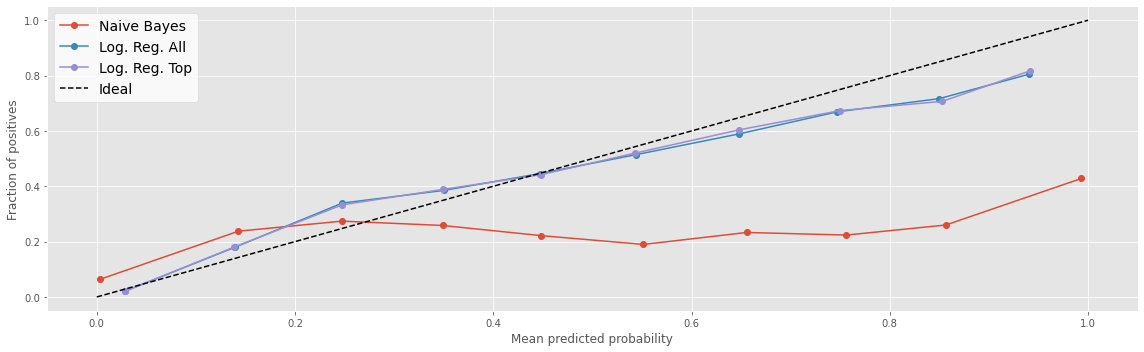

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))

ax.plot(prob_pred_nb, prob_true_nb, 'o-', label='Naive Bayes')
ax.plot(prob_pred_lr_all, prob_true_lr_all, 'o-', label='Log. Reg. All')
ax.plot(prob_pred_lr_top, prob_true_lr_top, 'o-', label='Log. Reg. Top')

ax.plot([0, 1], [0, 1], 'k--', label='Ideal')

# add legend with white background
legend = ax.legend(frameon=1, fontsize=14)
frame = legend.get_frame()
frame.set_facecolor('w')

ax.set_ylabel('Fraction of positives')
ax.set_xlabel('Mean predicted probability')

plt.tight_layout()

In [121]:
# calibrate logistic regression classifier trained on all data
lr_all_isotonic = CalibratedClassifierCV(lr_clf_all, cv=3, method="isotonic")
# retrain model on train dataset
lr_all_isotonic.fit(X_train, y_train)

# logistic regression trained on all features, isotonic calibration
pred_prob_lr_all_i = lr_all_isotonic.predict_proba(X_train)
prob_true_lr_all_i, prob_pred_lr_all_i = calibration_curve(y_train, pred_prob_lr_all_i[:, 1], n_bins=10)

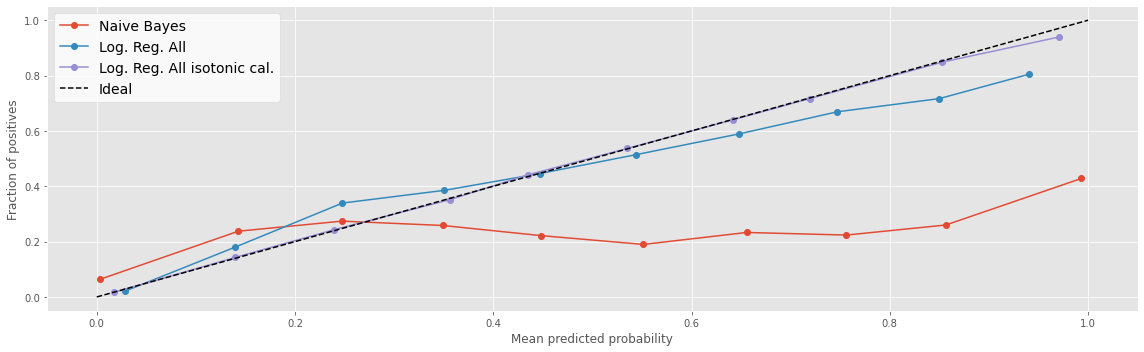

In [122]:
fig, ax = plt.subplots(1, 1, figsize=(16, 5))

ax.plot(prob_pred_nb, prob_true_nb, 'o-', label='Naive Bayes')
ax.plot(prob_pred_lr_all, prob_true_lr_all, 'o-', label='Log. Reg. All')
ax.plot(prob_pred_lr_all_i, prob_true_lr_all_i, 'o-', label='Log. Reg. All isotonic cal.')

ax.plot([0, 1], [0, 1], 'k--', label='Ideal')

# add legend with white background
legend = ax.legend(frameon=1, fontsize=14)
frame = legend.get_frame()
frame.set_facecolor('w')

ax.set_ylabel('Fraction of positives')
ax.set_xlabel('Mean predicted probability')

plt.tight_layout()

In [123]:
pred_cal = lr_all_isotonic.predict(X_test)

print('Calibrated logistic regression classifier')

# # calculate baseline accuracy, precision and recall
_accuracy = accuracy_score(pred_cal, y_test)
_recall = recall_score(pred_cal, y_test) 
_precision = precision_score(pred_cal, y_test)
_f1 = f1_score(pred_cal, y_test)

print(f'Accuracy:  {_accuracy:.3f}')
print(f'Precision: {_precision:.3f}')
print(f'Recall:    {_recall:.3f}')
print(f'F-1:       {_f1:.3f}')

Calibrated logistic regression classifier
Accuracy:  0.896
Precision: 0.272
Recall:    0.639
F-1:       0.381


Prescision was reduced, recall increased compared to uncalibrated Log. Reg. model.